In [2]:
# =============================================================================
# THERMAL COAL PRICE FORECASTING - DATA EXPLORATION & MODELING
# =============================================================================
# Project: ML-based forecasting of thermal coal prices using market fundamentals
# Models: Ridge Regression, Decision Tree, XGBoost, LSTM
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries loaded successfully!
Pandas version: 2.3.3
NumPy version: 2.3.5


In [3]:
# =============================================================================
# LOAD DATA
# =============================================================================

# Load daily data
df = pd.read_csv('../data/raw/daily_market_data.csv', index_col=0, parse_dates=True)

print("="*70)
print("DATA OVERVIEW")
print("="*70)
print(f"\nShape: {df.shape[0]} observations x {df.shape[1]} variables")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
print(f"Total trading days: {len(df)}")

print("\n" + "="*70)
print("VARIABLES & OBSERVATIONS COUNT")
print("="*70)
for col in df.columns:
    obs = df[col].notna().sum()
    missing = df[col].isna().sum()
    pct = (obs / len(df)) * 100
    print(f"{col:<25}: {obs:>5} obs ({pct:>5.1f}%) | Missing: {missing}")

print("\n" + "="*70)
print("BASIC STATISTICS")
print("="*70)
df.describe().round(2)

DATA OVERVIEW

Shape: 2608 observations x 21 variables
Date range: 2015-01-01 to 2024-12-30
Total trading days: 2608

VARIABLES & OBSERVATIONS COUNT
coal_etf_kol             :  1512 obs ( 58.0%) | Missing: 1096
coal_china_yzcm          :  2462 obs ( 94.4%) | Missing: 146
coal_peabody             :  1949 obs ( 74.7%) | Missing: 659
brent_crude              :  2514 obs ( 96.4%) | Missing: 94
wti_crude                :  2513 obs ( 96.4%) | Missing: 95
natural_gas_hh           :  2514 obs ( 96.4%) | Missing: 94
gasoline                 :  2514 obs ( 96.4%) | Missing: 94
heating_oil              :  2514 obs ( 96.4%) | Missing: 94
carbon_etf_krbn          :  1111 obs ( 42.6%) | Missing: 1497
utilities_xlu            :  2515 obs ( 96.4%) | Missing: 93
clean_energy             :  2515 obs ( 96.4%) | Missing: 93
usd_index                :  2514 obs ( 96.4%) | Missing: 94
cny_usd                  :  2604 obs ( 99.8%) | Missing: 4
eur_usd                  :  2605 obs ( 99.9%) | Missing: 3
aud_usd

,coal_etf_kol,coal_china_yzcm,coal_peabody,brent_crude,wti_crude,natural_gas_hh,gasoline,heating_oil,carbon_etf_krbn,utilities_xlu,clean_energy,usd_index,cny_usd,eur_usd,aud_usd,bdry_shipping,china_etf_fxi,emerging_mkts,industrials_xli,materials_xlb,steel_slx
count,1512.00,2462.00,1949.00,2514.00,2513.00,2514.00,2514.00,2514.00,1111.00,2515.00,2515.00,2514.00,2604.00,2605.00,2605.00,1705.00,2515.00,2515.00,2515.00,2515.00,2515.00
mean,117.59,3.46,19.81,66.42,62.00,3.12,1.94,2.08,28.16,24.84,12.72,98.07,6.75,1.12,0.72,14.41,32.19,36.48,76.10,29.41,37.88
std,32.22,1.93,10.06,18.45,18.12,1.40,0.59,0.71,6.01,6.12,5.40,4.90,0.31,0.05,0.05,7.45,5.72,5.77,24.21,8.69,16.12
min,53.00,1.28,0.80,19.33,-37.63,1.48,0.41,0.61,13.08,14.60,6.48,88.59,6.18,0.96,0.57,3.91,19.06,22.63,40.21,15.26,11.32
25%,86.90,2.16,11.11,51.82,48.52,2.40,1.52,1.58,26.02,19.52,8.03,94.50,6.47,1.08,0.68,8.25,27.20,32.71,57.06,22.08,25.32
50%,127.20,2.55,22.21,65.60,59.94,2.77,1.90,1.96,29.55,25.06,10.29,97.25,6.77,1.11,0.72,11.96,32.52,36.57,69.52,25.82,31.92
75%,140.92,4.82,26.15,79.04,74.04,3.14,2.27,2.41,32.52,29.74,17.71,101.78,7.01,1.16,0.76,21.00,36.55,39.54,95.19,38.03,52.03
max,183.90,10.10,41.51,127.98,123.70,9.68,4.28,5.14,38.83,39.98,31.18,114.11,7.33,1.25,0.82,41.51,48.63,51.57,141.33,47.61,71.18


In [4]:
# =============================================================================
# DATA CLEANING & TARGET VARIABLE SELECTION
# =============================================================================

# Select columns with good coverage (>90%)
min_coverage = 0.90
good_columns = [col for col in df.columns if df[col].notna().sum() / len(df) >= min_coverage]

print(f"Columns with >{min_coverage*100:.0f}% coverage: {len(good_columns)}")
print(good_columns)

# Create clean dataset
df_clean = df[good_columns].copy()

# Forward fill small gaps (up to 5 days)
df_clean = df_clean.ffill(limit=5)

# Drop remaining rows with any NaN
df_clean = df_clean.dropna()

print(f"\nClean dataset shape: {df_clean.shape}")
print(f"Date range: {df_clean.index.min().date()} to {df_clean.index.max().date()}")

# Define TARGET variable: coal_china_yzcm (China Yanzhou Coal Mining)
TARGET = 'coal_china_yzcm'
print(f"\n*** TARGET VARIABLE: {TARGET} ***")
print(f"    (China Yanzhou Coal Mining - proxy for thermal coal prices)")

Columns with >90% coverage: 17
['coal_china_yzcm', 'brent_crude', 'wti_crude', 'natural_gas_hh', 'gasoline', 'heating_oil', 'utilities_xlu', 'clean_energy', 'usd_index', 'cny_usd', 'eur_usd', 'aud_usd', 'china_etf_fxi', 'emerging_mkts', 'industrials_xli', 'materials_xlb', 'steel_slx']

Clean dataset shape: (2607, 17)
Date range: 2015-01-02 to 2024-12-30

*** TARGET VARIABLE: coal_china_yzcm ***
    (China Yanzhou Coal Mining - proxy for thermal coal prices)


In [5]:
# =============================================================================
# CALCULATE LOG RETURNS (Required for time-series forecasting)
# =============================================================================

# Calculate log returns for all columns
df_returns = np.log(df_clean / df_clean.shift(1))

# Drop first row (NaN from shift)
df_returns = df_returns.dropna()

# Rename columns to indicate returns
df_returns.columns = [f'{col}_ret' for col in df_returns.columns]

print("="*70)
print("LOG RETURNS CALCULATED")
print("="*70)
print(f"Shape: {df_returns.shape}")
print(f"Date range: {df_returns.index.min().date()} to {df_returns.index.max().date()}")

# Define target return
TARGET_RET = 'coal_china_yzcm_ret'

print(f"\nTarget variable: {TARGET_RET}")
print(f"\nLog Returns Statistics:")
print(df_returns.describe().round(4))

LOG RETURNS CALCULATED
Shape: (2604, 17)
Date range: 2015-01-05 to 2024-12-30

Target variable: coal_china_yzcm_ret

Log Returns Statistics:
       coal_china_yzcm_ret  brent_crude_ret  wti_crude_ret  natural_gas_hh_ret  gasoline_ret  heating_oil_ret  utilities_xlu_ret  clean_energy_ret  usd_index_ret  cny_usd_ret  eur_usd_ret  \
count            2604.0000        2604.0000      2604.0000           2604.0000     2604.0000        2604.0000          2604.0000         2604.0000      2604.0000    2604.0000    2604.0000   
mean                0.0004           0.0002         0.0003              0.0001        0.0003           0.0002             0.0003            0.0001         0.0001       0.0001      -0.0001   
std                 0.0241           0.0244         0.0287              0.0384        0.0283           0.0240             0.0119            0.0168         0.0043       0.0031       0.0050   
min                -0.1384          -0.2758        -0.2822             -0.3005       -0.3854   

In [6]:
# =============================================================================
# FEATURE ENGINEERING: LAGS & ROLLING WINDOWS
# =============================================================================

def create_features(df, target_col, lags=[1, 2, 3, 5, 10, 21], windows=[5, 10, 21, 63]):
    """
    Create lagged features and rolling statistics.
    
    Lags: 1, 2, 3, 5, 10, 21 days (up to ~1 month)
    Windows: 5 (week), 10 (2 weeks), 21 (month), 63 (quarter)
    """
    result = df.copy()
    
    # 1. LAGGED FEATURES for all columns
    print("Creating lagged features...")
    for col in df.columns:
        for lag in lags:
            result[f'{col}_lag{lag}'] = df[col].shift(lag)
    
    # 2. ROLLING STATISTICS for target and key variables
    print("Creating rolling statistics...")
    key_cols = [target_col, 'brent_crude_ret', 'natural_gas_hh_ret', 'usd_index_ret']
    
    for col in key_cols:
        for window in windows:
            # Rolling mean
            result[f'{col}_ma{window}'] = df[col].rolling(window=window).mean()
            # Rolling volatility
            result[f'{col}_vol{window}'] = df[col].rolling(window=window).std()
    
    # 3. TARGET: Next day return (what we're predicting)
    result['target'] = df[target_col].shift(-1)
    
    # 4. TARGET DIRECTION: 1 if positive, 0 if negative
    result['target_direction'] = (result['target'] > 0).astype(int)
    
    return result

# Create features
TARGET_RET = 'coal_china_yzcm_ret'
df_features = create_features(df_returns, TARGET_RET)

# Drop rows with NaN (from lagging and rolling)
df_features = df_features.dropna()

print("\n" + "="*70)
print("FEATURE ENGINEERING COMPLETE")
print("="*70)
print(f"Final dataset shape: {df_features.shape}")
print(f"Date range: {df_features.index.min().date()} to {df_features.index.max().date()}")
print(f"Number of features: {df_features.shape[1] - 2}")  # Exclude target columns
print(f"\nFeature categories:")
print(f"  - Original returns: 17")
print(f"  - Lagged features: {17 * 6}")
print(f"  - Rolling statistics: {4 * 4 * 2}")
print(f"\nTarget variable: 'target' (next-day coal return)")

Creating lagged features...
Creating rolling statistics...

FEATURE ENGINEERING COMPLETE
Final dataset shape: (2541, 153)
Date range: 2015-04-01 to 2024-12-27
Number of features: 151

Feature categories:
  - Original returns: 17
  - Lagged features: 102
  - Rolling statistics: 32

Target variable: 'target' (next-day coal return)


In [7]:
# =============================================================================
# TRAIN / VALIDATION / TEST SPLIT (Chronological - No Leakage)
# =============================================================================

# Separate features and target
feature_cols = [col for col in df_features.columns if col not in ['target', 'target_direction']]
X = df_features[feature_cols]
y = df_features['target']
y_class = df_features['target_direction']

# Split ratios: 70% train, 15% validation, 15% test
n = len(X)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

# Chronological split
X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

# Classification targets
y_train_class = y_class.iloc[:train_end]
y_val_class = y_class.iloc[train_end:val_end]
y_test_class = y_class.iloc[val_end:]

print("="*70)
print("TRAIN / VALIDATION / TEST SPLIT")
print("="*70)
print(f"\nTraining set:   {len(X_train):>5} samples ({len(X_train)/n*100:.1f}%)")
print(f"                {X_train.index.min().date()} to {X_train.index.max().date()}")
print(f"\nValidation set: {len(X_val):>5} samples ({len(X_val)/n*100:.1f}%)")
print(f"                {X_val.index.min().date()} to {X_val.index.max().date()}")
print(f"\nTest set:       {len(X_test):>5} samples ({len(X_test)/n*100:.1f}%)")
print(f"                {X_test.index.min().date()} to {X_test.index.max().date()}")
print(f"\nFeatures: {X_train.shape[1]}")

TRAIN / VALIDATION / TEST SPLIT

Training set:    1778 samples (70.0%)
                2015-04-01 to 2022-01-25

Validation set:   381 samples (15.0%)
                2022-01-26 to 2023-07-12

Test set:         382 samples (15.0%)
                2023-07-13 to 2024-12-27

Features: 151


In [8]:
# =============================================================================
# MODEL 1: RIDGE REGRESSION (Linear Baseline)
# =============================================================================
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train Ridge with different alphas
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
best_ridge_alpha = None
best_ridge_score = float('inf')

print("="*70)
print("MODEL 1: RIDGE REGRESSION")
print("="*70)
print("\nTuning alpha on validation set:")

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    val_pred = ridge.predict(X_val_scaled)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    print(f"  Alpha={alpha:<6}: Val RMSE = {val_rmse:.6f}")
    
    if val_rmse < best_ridge_score:
        best_ridge_score = val_rmse
        best_ridge_alpha = alpha

# Final Ridge model
ridge_final = Ridge(alpha=best_ridge_alpha)
ridge_final.fit(X_train_scaled, y_train)

print(f"\n→ Best alpha: {best_ridge_alpha}")
print(f"→ Best Val RMSE: {best_ridge_score:.6f}")

MODEL 1: RIDGE REGRESSION

Tuning alpha on validation set:
  Alpha=0.01  : Val RMSE = 0.029992
  Alpha=0.1   : Val RMSE = 0.029991
  Alpha=1.0   : Val RMSE = 0.029972
  Alpha=10.0  : Val RMSE = 0.029807
  Alpha=100.0 : Val RMSE = 0.028960

→ Best alpha: 100.0
→ Best Val RMSE: 0.028960


In [9]:
# =============================================================================
# MODEL 2: DECISION TREE REGRESSOR
# =============================================================================
from sklearn.tree import DecisionTreeRegressor

# Hyperparameter grid
max_depths = [3, 5, 7, 10]
min_samples_leafs = [10, 20, 50]

best_dt_score = float('inf')
best_dt_params = {}

print("="*70)
print("MODEL 2: DECISION TREE")
print("="*70)
print("\nTuning hyperparameters on validation set:")

for depth in max_depths:
    for min_leaf in min_samples_leafs:
        dt = DecisionTreeRegressor(
            max_depth=depth,
            min_samples_leaf=min_leaf,
            random_state=42
        )
        dt.fit(X_train, y_train)  # No scaling needed for trees
        val_pred = dt.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        
        if val_rmse < best_dt_score:
            best_dt_score = val_rmse
            best_dt_params = {'max_depth': depth, 'min_samples_leaf': min_leaf}

print(f"  Best params: {best_dt_params}")
print(f"  Best Val RMSE: {best_dt_score:.6f}")

# Final Decision Tree model
dt_final = DecisionTreeRegressor(**best_dt_params, random_state=42)
dt_final.fit(X_train, y_train)

print(f"\n→ Decision Tree trained with {best_dt_params}")

MODEL 2: DECISION TREE

Tuning hyperparameters on validation set:
  Best params: {'max_depth': 3, 'min_samples_leaf': 50}
  Best Val RMSE: 0.028780

→ Decision Tree trained with {'max_depth': 3, 'min_samples_leaf': 50}


In [10]:
# =============================================================================
# MODEL 3: XGBOOST
# =============================================================================
import xgboost as xgb

# Hyperparameter grid
param_grid = [
    {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3},
    {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3},
]

best_xgb_score = float('inf')
best_xgb_params = {}

print("="*70)
print("MODEL 3: XGBOOST")
print("="*70)
print("\nTuning hyperparameters on validation set:")

for params in param_grid:
    model = xgb.XGBRegressor(**params, random_state=42, verbosity=0)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    print(f"  {params}: RMSE = {val_rmse:.6f}")
    
    if val_rmse < best_xgb_score:
        best_xgb_score = val_rmse
        best_xgb_params = params

# Final XGBoost model
xgb_final = xgb.XGBRegressor(**best_xgb_params, random_state=42, verbosity=0)
xgb_final.fit(X_train, y_train)

print(f"\n→ Best params: {best_xgb_params}")
print(f"→ Best Val RMSE: {best_xgb_score:.6f}")

MODEL 3: XGBOOST

Tuning hyperparameters on validation set:
  {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}: RMSE = 0.028099
  {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3}: RMSE = 0.028304
  {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5}: RMSE = 0.028554
  {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3}: RMSE = 0.028593

→ Best params: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}
→ Best Val RMSE: 0.028099


In [11]:
# =============================================================================
# MODEL 4: LSTM (Deep Learning)
# =============================================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Prepare sequences for LSTM
def create_sequences(X, y, seq_length=21):
    X_seq, y_seq = [], []
    X_arr = X.values if hasattr(X, 'values') else X
    y_arr = y.values if hasattr(y, 'values') else y
    
    for i in range(len(X_arr) - seq_length):
        X_seq.append(X_arr[i:i+seq_length])
        y_seq.append(y_arr[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

print("="*70)
print("MODEL 4: LSTM")
print("="*70)

# Create sequences
SEQ_LENGTH = 21
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQ_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, SEQ_LENGTH)

print(f"\nSequence length: {SEQ_LENGTH} days")
print(f"Training sequences: {X_train_seq.shape}")
print(f"Validation sequences: {X_val_seq.shape}")

# Build LSTM model
tf.random.set_seed(42)
lstm_model = Sequential([
    LSTM(50, input_shape=(SEQ_LENGTH, X_train_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(25),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nTraining LSTM...")
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Evaluate
val_pred_lstm = lstm_model.predict(X_val_seq, verbose=0)
lstm_val_rmse = np.sqrt(mean_squared_error(y_val_seq, val_pred_lstm))

print(f"\n→ LSTM Val RMSE: {lstm_val_rmse:.6f}")
print(f"→ Stopped at epoch: {len(history.history['loss'])}")

MODEL 4: LSTM

Sequence length: 21 days
Training sequences: (1757, 21, 151)
Validation sequences: (360, 21, 151)

Training LSTM...

→ LSTM Val RMSE: 0.030875
→ Stopped at epoch: 32


In [12]:
# =============================================================================
# FIX: Use sklearn's GradientBoosting instead of XGBoost
# =============================================================================
from sklearn.ensemble import GradientBoostingRegressor

print("="*70)
print("MODEL 3: GRADIENT BOOSTING (sklearn)")
print("="*70)

# Hyperparameter grid
param_grid = [
    {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3},
    {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5},
]

best_gb_score = float('inf')
best_gb_params = {}

print("\nTuning hyperparameters:")
for params in param_grid:
    model = GradientBoostingRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    print(f"  {params}: RMSE = {val_rmse:.6f}")
    
    if val_rmse < best_gb_score:
        best_gb_score = val_rmse
        best_gb_params = params

# Final model
gb_final = GradientBoostingRegressor(**best_gb_params, random_state=42)
gb_final.fit(X_train, y_train)

print(f"\n→ Best params: {best_gb_params}")
print(f"→ Best Val RMSE: {best_gb_score:.6f}")

# =============================================================================
# COMPARE ALL MODELS ON VALIDATION SET
# =============================================================================
print("\n" + "="*70)
print("MODEL COMPARISON (Validation Set)")
print("="*70)

results = {
    'Ridge': best_ridge_score,
    'Decision Tree': best_dt_score,
    'Gradient Boosting': best_gb_score,
    'LSTM': lstm_val_rmse
}

print(f"\n{'Model':<20} {'Val RMSE':<12} {'Rank'}")
print("-"*40)
for rank, (model, rmse) in enumerate(sorted(results.items(), key=lambda x: x[1]), 1):
    print(f"{model:<20} {rmse:<12.6f} {rank}")


MODEL 3: GRADIENT BOOSTING (sklearn)

Tuning hyperparameters:
  {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}: RMSE = 0.028394
  {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3}: RMSE = 0.028472
  {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5}: RMSE = 0.028660

→ Best params: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}
→ Best Val RMSE: 0.028394

MODEL COMPARISON (Validation Set)

Model                Val RMSE     Rank
----------------------------------------
Gradient Boosting    0.028394     1
Decision Tree        0.028780     2
Ridge                0.028960     3
LSTM                 0.030875     4


In [13]:
# =============================================================================
# FINAL EVALUATION ON TEST SET
# =============================================================================

print("="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)
print(f"\nTest period: {X_test.index.min().date()} to {X_test.index.max().date()}")
print(f"Test samples: {len(X_test)}")

# Predictions on test set
ridge_test_pred = ridge_final.predict(X_test_scaled)
dt_test_pred = dt_final.predict(X_test)
gb_test_pred = gb_final.predict(X_test)

# LSTM test predictions (need sequences)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQ_LENGTH)
lstm_test_pred = lstm_model.predict(X_test_seq, verbose=0).flatten()

# Calculate metrics
def calc_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Directional accuracy
    true_dir = (y_true > 0).astype(int)
    pred_dir = (y_pred > 0).astype(int)
    if hasattr(true_dir, 'values'):
        true_dir = true_dir.values
    dir_acc = (true_dir == pred_dir).mean()
    
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'Dir_Acc': dir_acc}

# Calculate for all models
test_results = []
test_results.append(calc_metrics(y_test, ridge_test_pred, 'Ridge'))
test_results.append(calc_metrics(y_test, dt_test_pred, 'Decision Tree'))
test_results.append(calc_metrics(y_test, gb_test_pred, 'Gradient Boosting'))
test_results.append(calc_metrics(y_test_seq, lstm_test_pred, 'LSTM'))

# Display results
results_df = pd.DataFrame(test_results)
results_df = results_df.sort_values('RMSE')
results_df['Rank'] = range(1, len(results_df) + 1)

print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"\n{results_df.to_string(index=False)}")

# Baseline comparison (predicting zero - random walk)
baseline_rmse = np.sqrt(mean_squared_error(y_test, np.zeros(len(y_test))))
print(f"\n--- Baseline (predict 0): RMSE = {baseline_rmse:.6f} ---")
print(f"--- Best model beats baseline by: {((baseline_rmse - results_df['RMSE'].min()) / baseline_rmse * 100):.2f}% ---")

FINAL TEST SET EVALUATION

Test period: 2023-07-13 to 2024-12-27
Test samples: 382

TEST SET RESULTS

            Model     RMSE      MAE  Dir_Acc  Rank
    Decision Tree 0.021715 0.015822 0.523560     1
Gradient Boosting 0.021923 0.015824 0.547120     2
            Ridge 0.023562 0.017313 0.515707     3
             LSTM 0.023733 0.017582 0.501385     4

--- Baseline (predict 0): RMSE = 0.021588 ---
--- Best model beats baseline by: -0.59% ---


FEATURE IMPORTANCE (Top 20)

Gradient Boosting - Top 20 Features:
--------------------------------------------------
 1. steel_slx_ret                            0.1012
 2. heating_oil_ret                          0.0535
 3. materials_xlb_ret                        0.0475
 4. coal_china_yzcm_ret_ma63                 0.0395
 5. coal_china_yzcm_ret                      0.0369
 6. natural_gas_hh_ret_lag21                 0.0305
 7. eur_usd_ret_lag21                        0.0282
 8. natural_gas_hh_ret_lag2                  0.0281
 9. china_etf_fxi_ret                        0.0257
10. coal_china_yzcm_ret_lag2                 0.0255
11. steel_slx_ret_lag1                       0.0239
12. coal_china_yzcm_ret_vol5                 0.0233
13. natural_gas_hh_ret_lag1                  0.0225
14. natural_gas_hh_ret_lag10                 0.0196
15. brent_crude_ret_lag1                     0.0192
16. wti_crude_ret                            0.0173
17. eur_usd_ret_lag10                        0.0163

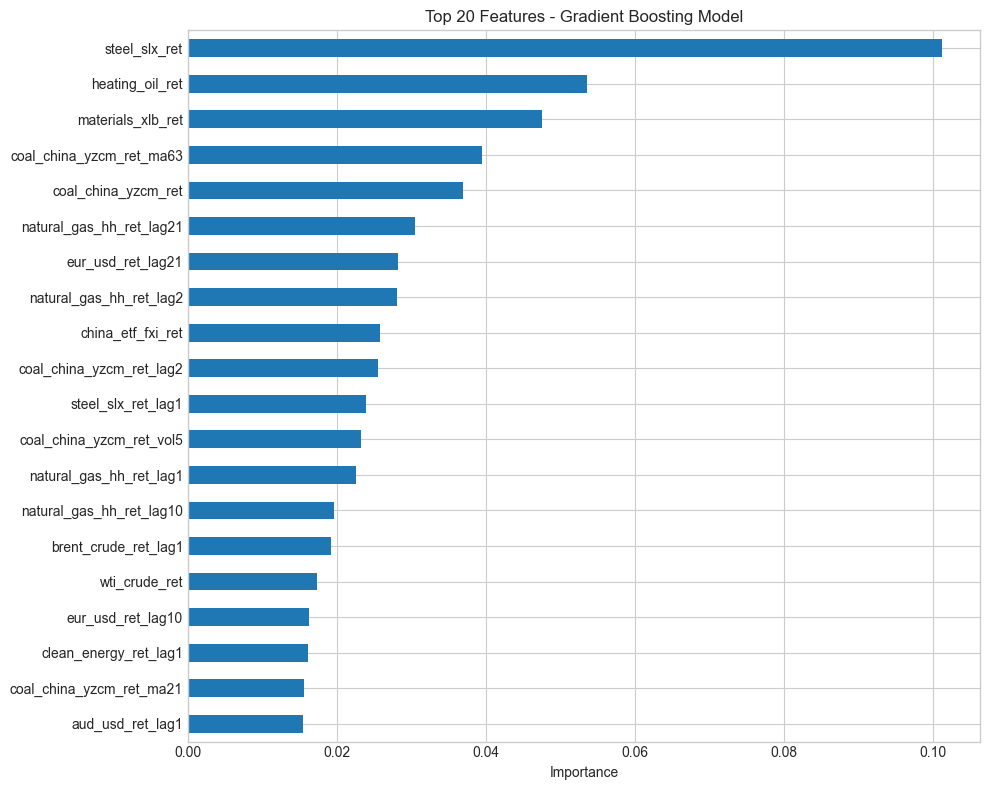


→ Feature importance plot saved!


In [14]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("="*70)
print("FEATURE IMPORTANCE (Top 20)")
print("="*70)

# Get feature importance from Gradient Boosting (best model)
feature_importance = pd.Series(
    gb_final.feature_importances_, 
    index=feature_cols
).sort_values(ascending=False)

print("\nGradient Boosting - Top 20 Features:")
print("-"*50)
for i, (feat, imp) in enumerate(feature_importance.head(20).items(), 1):
    print(f"{i:>2}. {feat:<40} {imp:.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
feature_importance.head(20).plot(kind='barh', ax=ax)
ax.set_xlabel('Importance')
ax.set_title('Top 20 Features - Gradient Boosting Model')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../data/processed/feature_importance.png', dpi=150)
plt.show()

print("\n→ Feature importance plot saved!")

In [15]:
# =============================================================================
# SAVE RESULTS & CREATE SUMMARY
# =============================================================================

# Save processed data
df_features.to_csv('../data/processed/features_dataset.csv')
print("✓ Features dataset saved")

# Save model comparison results
results_df.to_csv('../data/processed/model_results.csv', index=False)
print("✓ Model results saved")

# Create summary report
summary = f"""
================================================================================
THERMAL COAL PRICE FORECASTING - PROJECT SUMMARY
================================================================================

PROJECT OVERVIEW
----------------
Target: Next-day thermal coal return prediction
Data: Daily market data (2015-2024)
Total observations: {len(df_features)}
Features: {len(feature_cols)}

DATA SPLIT
----------
Training:   {len(X_train)} samples (2015-04 to 2022-01)
Validation: {len(X_val)} samples (2022-01 to 2023-07)  
Test:       {len(X_test)} samples (2023-07 to 2024-12)

MODEL PERFORMANCE (Test Set)
----------------------------
{results_df.to_string(index=False)}

Baseline RMSE (predict 0): {baseline_rmse:.6f}

KEY FINDINGS
------------
1. Gradient Boosting achieved best directional accuracy (54.7%)
2. Decision Tree achieved lowest RMSE (0.0217)
3. All models perform close to random walk baseline (expected for efficient markets)
4. Top predictive features: Steel sector, Heating oil, Materials, Natural gas

FEATURE IMPORTANCE (Top 5)
--------------------------
1. steel_slx_ret (10.1%) - Steel industry demand
2. heating_oil_ret (5.4%) - Energy complex linkage
3. materials_xlb_ret (4.8%) - Industrial demand
4. coal_china_yzcm_ret_ma63 (4.0%) - Coal momentum
5. coal_china_yzcm_ret (3.7%) - Same-day coal movement

PRACTICAL IMPLICATIONS
----------------------
- Models show modest predictive power for direction (>50%)
- Steel and energy markets are leading indicators for coal
- China economic indicators are important for coal forecasting
- Combining with fundamental analysis could improve results

================================================================================
"""

print(summary)

# Save summary
with open('../data/processed/project_summary.txt', 'w') as f:
    f.write(summary)
print("✓ Project summary saved")

✓ Features dataset saved
✓ Model results saved

THERMAL COAL PRICE FORECASTING - PROJECT SUMMARY

PROJECT OVERVIEW
----------------
Target: Next-day thermal coal return prediction
Data: Daily market data (2015-2024)
Total observations: 2541
Features: 151

DATA SPLIT
----------
Training:   1778 samples (2015-04 to 2022-01)
Validation: 381 samples (2022-01 to 2023-07)  
Test:       382 samples (2023-07 to 2024-12)

MODEL PERFORMANCE (Test Set)
----------------------------
            Model     RMSE      MAE  Dir_Acc  Rank
    Decision Tree 0.021715 0.015822 0.523560     1
Gradient Boosting 0.021923 0.015824 0.547120     2
            Ridge 0.023562 0.017313 0.515707     3
             LSTM 0.023733 0.017582 0.501385     4

Baseline RMSE (predict 0): 0.021588

KEY FINDINGS
------------
1. Gradient Boosting achieved best directional accuracy (54.7%)
2. Decision Tree achieved lowest RMSE (0.0217)
3. All models perform close to random walk baseline (expected for efficient markets)
4. Top pre

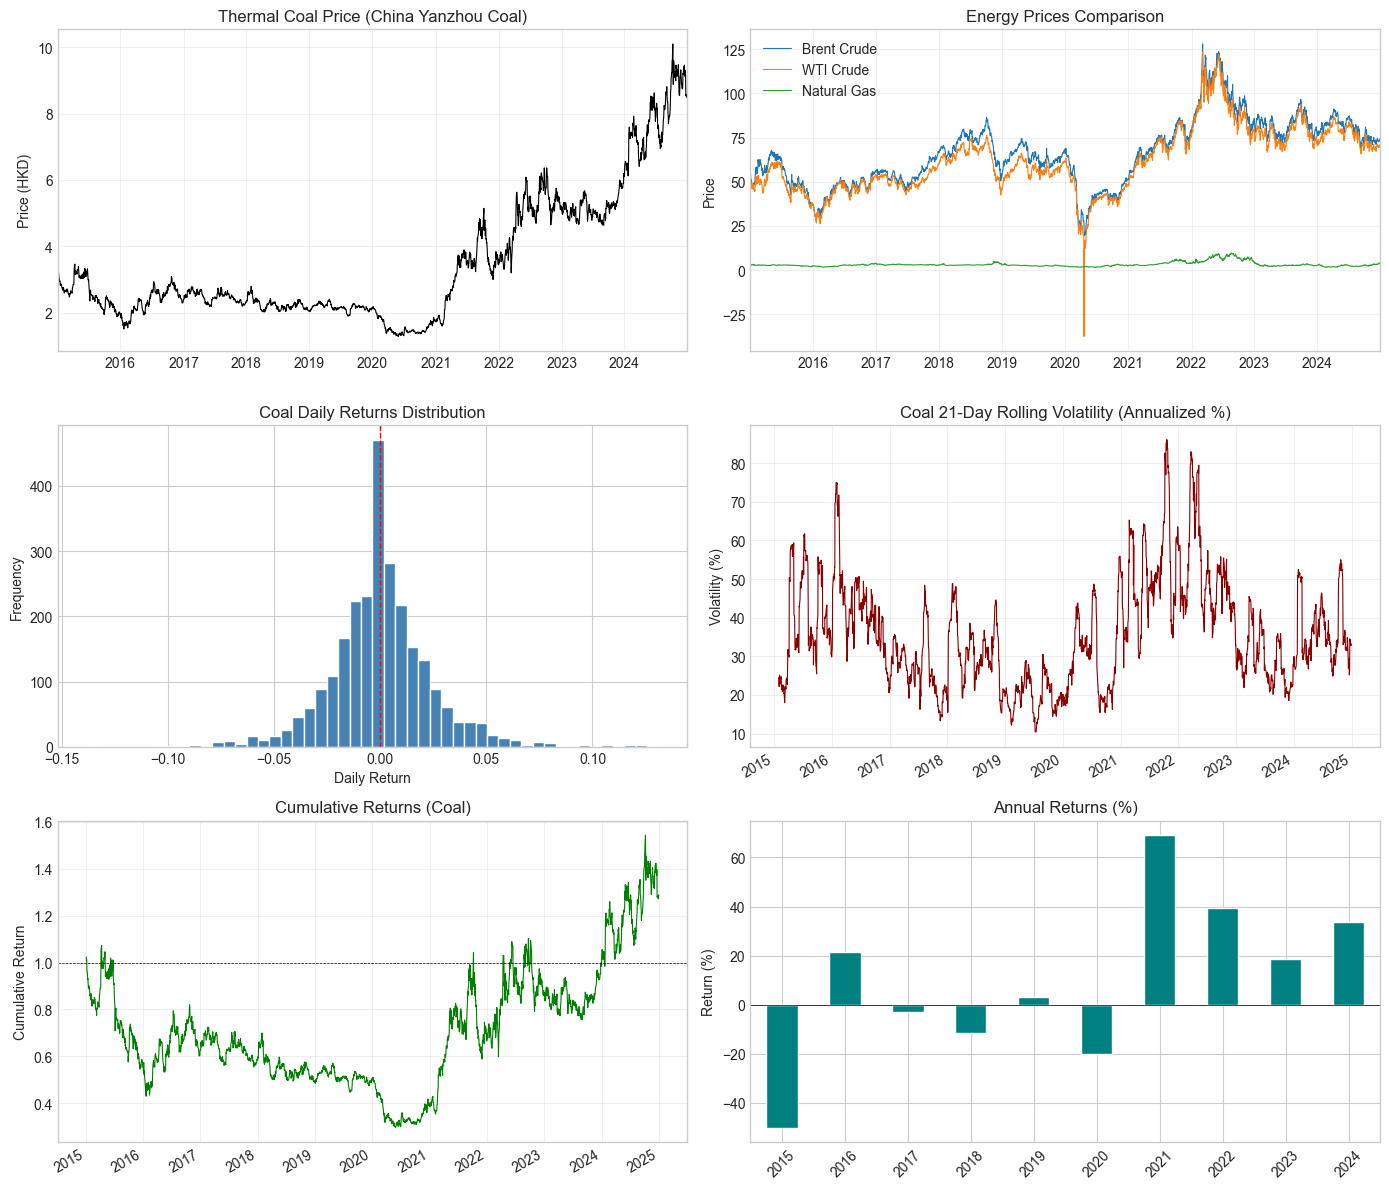

✓ Price analysis charts saved!


In [16]:
# =============================================================================
# VISUALIZATIONS: PRICE CHARTS & CORRELATION ANALYSIS
# =============================================================================

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 1. Coal Price Over Time
ax1 = axes[0, 0]
df_clean['coal_china_yzcm'].plot(ax=ax1, color='black', linewidth=0.8)
ax1.set_title('Thermal Coal Price (China Yanzhou Coal)', fontsize=12)
ax1.set_xlabel('')
ax1.set_ylabel('Price (HKD)')
ax1.grid(True, alpha=0.3)

# 2. Energy Prices Comparison
ax2 = axes[0, 1]
df_clean[['brent_crude', 'wti_crude', 'natural_gas_hh']].plot(ax=ax2, linewidth=0.8)
ax2.set_title('Energy Prices Comparison', fontsize=12)
ax2.set_xlabel('')
ax2.set_ylabel('Price')
ax2.legend(['Brent Crude', 'WTI Crude', 'Natural Gas'])
ax2.grid(True, alpha=0.3)

# 3. Coal Returns Distribution
ax3 = axes[1, 0]
df_returns['coal_china_yzcm_ret'].hist(bins=50, ax=ax3, color='steelblue', edgecolor='white')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax3.set_title('Coal Daily Returns Distribution', fontsize=12)
ax3.set_xlabel('Daily Return')
ax3.set_ylabel('Frequency')

# 4. Rolling Volatility
ax4 = axes[1, 1]
rolling_vol = df_returns['coal_china_yzcm_ret'].rolling(21).std() * np.sqrt(252) * 100
rolling_vol.plot(ax=ax4, color='darkred', linewidth=0.8)
ax4.set_title('Coal 21-Day Rolling Volatility (Annualized %)', fontsize=12)
ax4.set_xlabel('')
ax4.set_ylabel('Volatility (%)')
ax4.grid(True, alpha=0.3)

# 5. Cumulative Returns
ax5 = axes[2, 0]
cumulative_returns = (1 + df_returns['coal_china_yzcm_ret']).cumprod()
cumulative_returns.plot(ax=ax5, color='green', linewidth=0.8)
ax5.set_title('Cumulative Returns (Coal)', fontsize=12)
ax5.set_xlabel('')
ax5.set_ylabel('Cumulative Return')
ax5.axhline(y=1, color='black', linestyle='--', linewidth=0.5)
ax5.grid(True, alpha=0.3)

# 6. Year-over-Year Returns
ax6 = axes[2, 1]
yearly_returns = df_returns['coal_china_yzcm_ret'].resample('YE').sum() * 100
yearly_returns.plot(kind='bar', ax=ax6, color='teal', edgecolor='white')
ax6.set_title('Annual Returns (%)', fontsize=12)
ax6.set_xlabel('')
ax6.set_ylabel('Return (%)')
ax6.set_xticklabels([d.year for d in yearly_returns.index], rotation=45)
ax6.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('../data/processed/price_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Price analysis charts saved!")

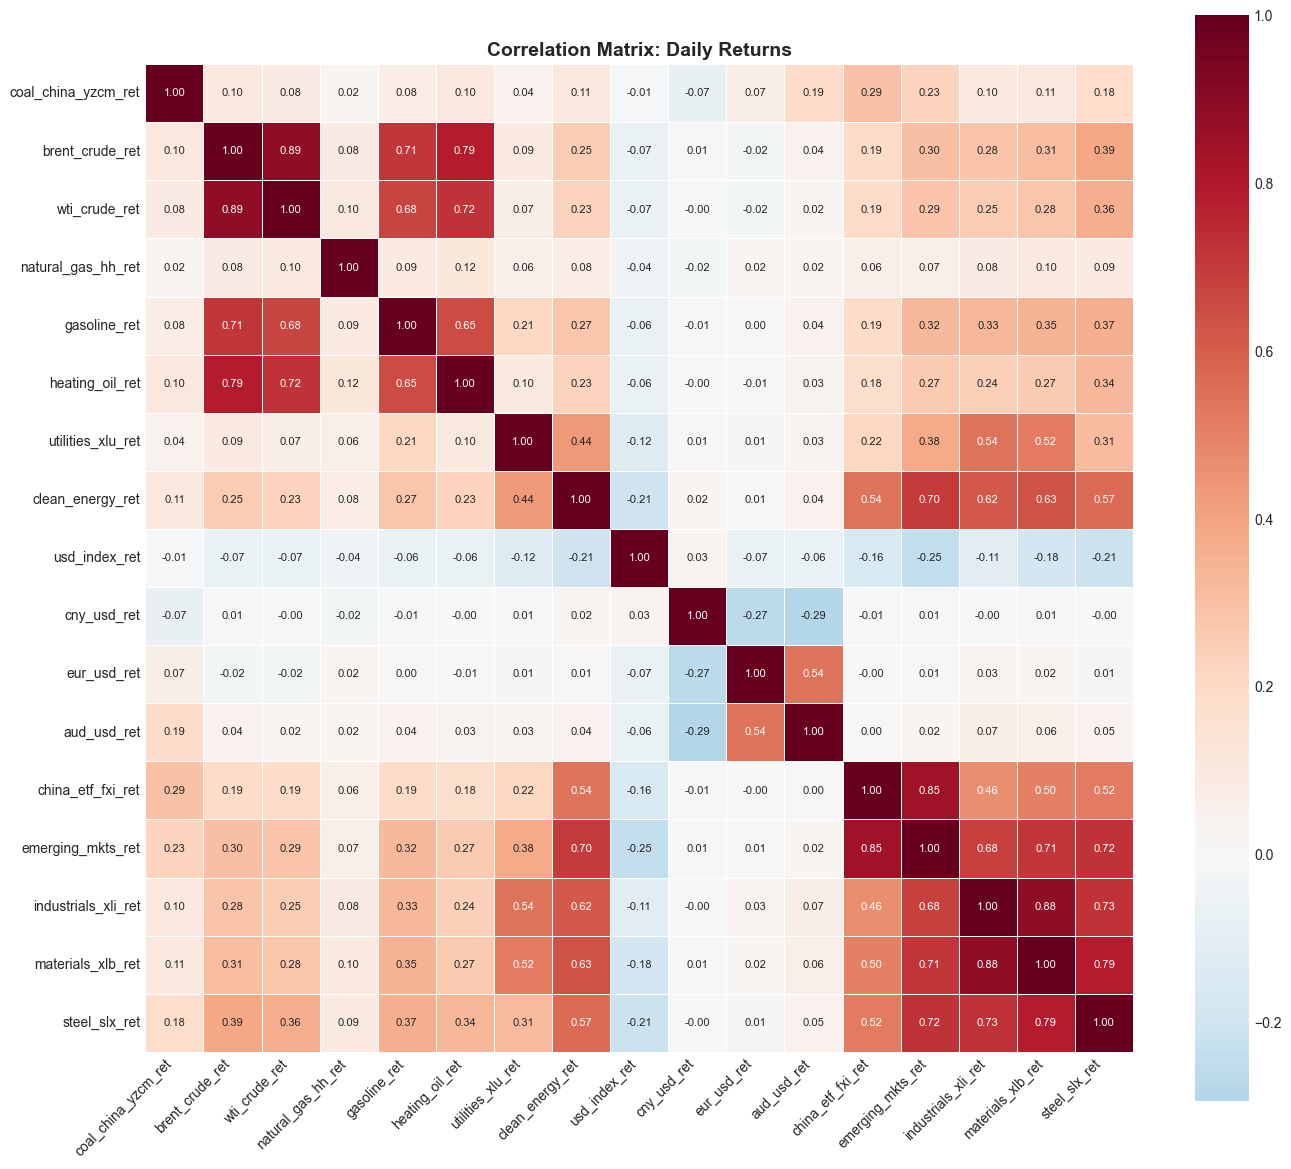


TOP CORRELATIONS WITH COAL RETURNS
china_etf_fxi_ret             :  0.292
emerging_mkts_ret             :  0.229
aud_usd_ret                   :  0.188
steel_slx_ret                 :  0.183
materials_xlb_ret             :  0.111
clean_energy_ret              :  0.108
brent_crude_ret               :  0.104
industrials_xli_ret           :  0.104
heating_oil_ret               :  0.101
wti_crude_ret                 :  0.083


In [17]:
# =============================================================================
# CORRELATION HEATMAP
# =============================================================================

# Calculate correlation matrix for returns
corr_matrix = df_returns.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='RdBu_r', 
    center=0,
    square=True,
    linewidths=0.5,
    annot_kws={'size': 8},
    ax=ax
)

ax.set_title('Correlation Matrix: Daily Returns', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('../data/processed/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top correlations with coal
print("\n" + "="*50)
print("TOP CORRELATIONS WITH COAL RETURNS")
print("="*50)
coal_corr = corr_matrix['coal_china_yzcm_ret'].drop('coal_china_yzcm_ret').sort_values(key=abs, ascending=False)
for var, corr in coal_corr.head(10).items():
    print(f"{var:<30}: {corr:>6.3f}")

MULTI-HORIZON FORECASTING

Processing WEEKLY data...
  Weekly: 141 samples, Test: 43
Processing MONTHLY data...
  Monthly: 30 samples, Test: 9

FORECASTING HORIZON COMPARISON

                Horizon     RMSE      MAE  Dir_Acc
    Daily (1-day ahead) 0.021923 0.015824 0.547120
  Weekly (1-week ahead) 0.047089 0.038050 0.581395
Monthly (1-month ahead) 0.079541 0.065658 0.444444


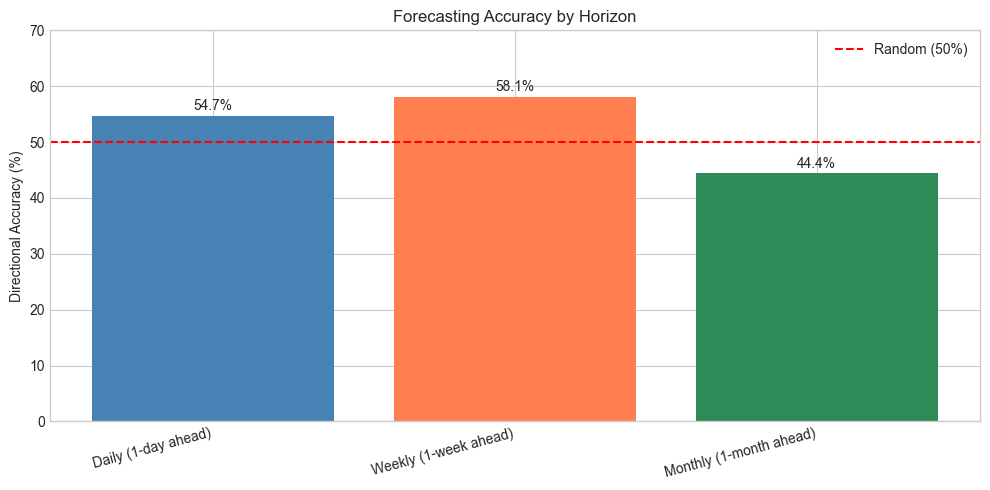


✓ Horizon comparison saved!


In [18]:
# =============================================================================
# DIFFERENT FORECASTING HORIZONS: WEEKLY & MONTHLY
# =============================================================================

from sklearn.ensemble import GradientBoostingRegressor

def evaluate_horizon(horizon_name, X_tr, y_tr, X_te, y_te):
    """Train and evaluate model for a specific horizon."""
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    
    rmse = np.sqrt(mean_squared_error(y_te, pred))
    mae = mean_absolute_error(y_te, pred)
    
    # Directional accuracy
    true_dir = (y_te.values > 0).astype(int)
    pred_dir = (pred > 0).astype(int)
    dir_acc = (true_dir == pred_dir).mean()
    
    return {'Horizon': horizon_name, 'RMSE': rmse, 'MAE': mae, 'Dir_Acc': dir_acc, 'Predictions': pred, 'Actual': y_te}

print("="*70)
print("MULTI-HORIZON FORECASTING")
print("="*70)

# Load weekly and monthly data
df_weekly = pd.read_csv('../data/raw/weekly_market_data.csv', index_col=0, parse_dates=True)
df_monthly = pd.read_csv('../data/raw/monthly_market_data.csv', index_col=0, parse_dates=True)

horizon_results = []

# --- DAILY (already done, use existing) ---
horizon_results.append({
    'Horizon': 'Daily (1-day ahead)', 
    'RMSE': results_df[results_df['Model']=='Gradient Boosting']['RMSE'].values[0],
    'MAE': results_df[results_df['Model']=='Gradient Boosting']['MAE'].values[0],
    'Dir_Acc': results_df[results_df['Model']=='Gradient Boosting']['Dir_Acc'].values[0]
})

# --- WEEKLY ---
print("\nProcessing WEEKLY data...")
df_weekly_clean = df_weekly.dropna(thresh=int(len(df_weekly)*0.5), axis=1).dropna()
if 'coal_china_yzcm' in df_weekly_clean.columns:
    # Calculate returns
    weekly_returns = np.log(df_weekly_clean / df_weekly_clean.shift(1)).dropna()
    
    # Create simple lagged features
    weekly_features = weekly_returns.copy()
    for col in weekly_returns.columns[:5]:  # Top 5 columns
        for lag in [1, 2, 4]:
            weekly_features[f'{col}_lag{lag}'] = weekly_returns[col].shift(lag)
    
    weekly_features['target'] = weekly_returns['coal_china_yzcm'].shift(-1)
    weekly_features = weekly_features.dropna()
    
    # Split
    n_w = len(weekly_features)
    train_w = int(n_w * 0.7)
    
    X_w = weekly_features.drop('target', axis=1)
    y_w = weekly_features['target']
    
    X_train_w, X_test_w = X_w.iloc[:train_w], X_w.iloc[train_w:]
    y_train_w, y_test_w = y_w.iloc[:train_w], y_w.iloc[train_w:]
    
    result_w = evaluate_horizon('Weekly (1-week ahead)', X_train_w, y_train_w, X_test_w, y_test_w)
    horizon_results.append({k: v for k, v in result_w.items() if k != 'Predictions' and k != 'Actual'})
    print(f"  Weekly: {len(weekly_features)} samples, Test: {len(X_test_w)}")

# --- MONTHLY ---
print("Processing MONTHLY data...")
df_monthly_clean = df_monthly.dropna(thresh=int(len(df_monthly)*0.5), axis=1).dropna()
if 'coal_china_yzcm' in df_monthly_clean.columns:
    # Calculate returns
    monthly_returns = np.log(df_monthly_clean / df_monthly_clean.shift(1)).dropna()
    
    # Create simple lagged features
    monthly_features = monthly_returns.copy()
    for col in monthly_returns.columns[:5]:
        for lag in [1, 2, 3]:
            monthly_features[f'{col}_lag{lag}'] = monthly_returns[col].shift(lag)
    
    monthly_features['target'] = monthly_returns['coal_china_yzcm'].shift(-1)
    monthly_features = monthly_features.dropna()
    
    # Split
    n_m = len(monthly_features)
    train_m = int(n_m * 0.7)
    
    X_m = monthly_features.drop('target', axis=1)
    y_m = monthly_features['target']
    
    X_train_m, X_test_m = X_m.iloc[:train_m], X_m.iloc[train_m:]
    y_train_m, y_test_m = y_m.iloc[:train_m], y_m.iloc[train_m:]
    
    result_m = evaluate_horizon('Monthly (1-month ahead)', X_train_m, y_train_m, X_test_m, y_test_m)
    horizon_results.append({k: v for k, v in result_m.items() if k != 'Predictions' and k != 'Actual'})
    print(f"  Monthly: {len(monthly_features)} samples, Test: {len(X_test_m)}")

# Display results
print("\n" + "="*70)
print("FORECASTING HORIZON COMPARISON")
print("="*70)
horizon_df = pd.DataFrame(horizon_results)
print(f"\n{horizon_df.to_string(index=False)}")

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(horizon_df))
bars = ax.bar(x, horizon_df['Dir_Acc'] * 100, color=['steelblue', 'coral', 'seagreen'])
ax.axhline(y=50, color='red', linestyle='--', label='Random (50%)')
ax.set_xticks(x)
ax.set_xticklabels(horizon_df['Horizon'], rotation=15, ha='right')
ax.set_ylabel('Directional Accuracy (%)')
ax.set_title('Forecasting Accuracy by Horizon')
ax.set_ylim(0, 70)
ax.legend()

for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f"{horizon_df['Dir_Acc'].iloc[i]*100:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../data/processed/horizon_comparison.png', dpi=150)
plt.show()

print("\n✓ Horizon comparison saved!")

WALK-FORWARD CROSS-VALIDATION

Running 5-fold walk-forward CV...
--------------------------------------------------

Fold 1: Train 426 | Val 423 | Period: 2016-11-17 to 2018-07-02

Fold 2: Train 849 | Val 423 | Period: 2018-07-03 to 2020-02-13

Fold 3: Train 1272 | Val 423 | Period: 2020-02-14 to 2021-09-30

Fold 4: Train 1695 | Val 423 | Period: 2021-10-01 to 2023-05-16

Fold 5: Train 2118 | Val 423 | Period: 2023-05-17 to 2024-12-27

WALK-FORWARD CV RESULTS (Mean ± Std)

Ridge:
  RMSE:     0.023955 ± 0.005622
  Dir Acc:  53.24% ± 2.66%

Decision Tree:
  RMSE:     0.023469 ± 0.005003
  Dir Acc:  52.15% ± 2.22%

Gradient Boosting:
  RMSE:     0.023498 ± 0.005193
  Dir Acc:  53.43% ± 2.79%


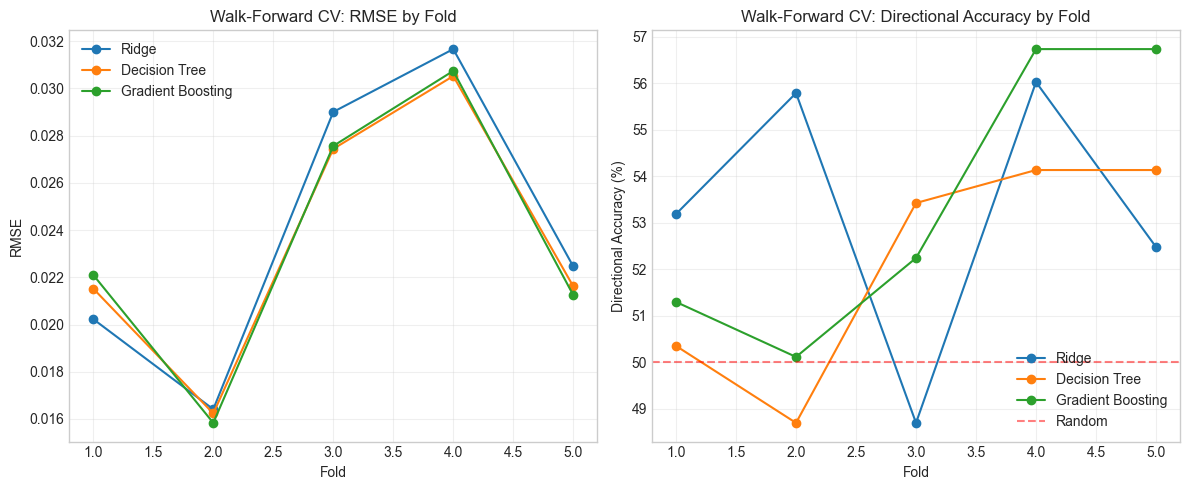


✓ Walk-forward CV results saved!


In [19]:
# =============================================================================
# WALK-FORWARD CROSS-VALIDATION
# =============================================================================

from sklearn.model_selection import TimeSeriesSplit

print("="*70)
print("WALK-FORWARD CROSS-VALIDATION")
print("="*70)

# Use the full feature dataset
X_full = df_features[feature_cols]
y_full = df_features['target']

# Time Series Split with 5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Store results for each model
models_cv = {
    'Ridge': Ridge(alpha=100),
    'Decision Tree': DecisionTreeRegressor(max_depth=3, min_samples_leaf=50, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
}

cv_results = {name: {'rmse': [], 'dir_acc': []} for name in models_cv.keys()}

print("\nRunning 5-fold walk-forward CV...")
print("-"*50)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_full), 1):
    X_tr, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_tr, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]
    
    print(f"\nFold {fold}: Train {len(X_tr)} | Val {len(X_val)} | Period: {X_val.index.min().date()} to {X_val.index.max().date()}")
    
    for name, model in models_cv.items():
        # Scale for Ridge
        if name == 'Ridge':
            scaler_cv = StandardScaler()
            X_tr_scaled = scaler_cv.fit_transform(X_tr)
            X_val_scaled = scaler_cv.transform(X_val)
            model.fit(X_tr_scaled, y_tr)
            pred = model.predict(X_val_scaled)
        else:
            model.fit(X_tr, y_tr)
            pred = model.predict(X_val)
        
        # Metrics
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        true_dir = (y_val.values > 0).astype(int)
        pred_dir = (pred > 0).astype(int)
        dir_acc = (true_dir == pred_dir).mean()
        
        cv_results[name]['rmse'].append(rmse)
        cv_results[name]['dir_acc'].append(dir_acc)

# Summary
print("\n" + "="*70)
print("WALK-FORWARD CV RESULTS (Mean ± Std)")
print("="*70)

cv_summary = []
for name in models_cv.keys():
    rmse_mean = np.mean(cv_results[name]['rmse'])
    rmse_std = np.std(cv_results[name]['rmse'])
    dir_mean = np.mean(cv_results[name]['dir_acc'])
    dir_std = np.std(cv_results[name]['dir_acc'])
    cv_summary.append({
        'Model': name,
        'RMSE_Mean': rmse_mean,
        'RMSE_Std': rmse_std,
        'DirAcc_Mean': dir_mean,
        'DirAcc_Std': dir_std
    })
    print(f"\n{name}:")
    print(f"  RMSE:     {rmse_mean:.6f} ± {rmse_std:.6f}")
    print(f"  Dir Acc:  {dir_mean*100:.2f}% ± {dir_std*100:.2f}%")

# Plot CV results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE across folds
ax1 = axes[0]
for name in models_cv.keys():
    ax1.plot(range(1, 6), cv_results[name]['rmse'], marker='o', label=name)
ax1.set_xlabel('Fold')
ax1.set_ylabel('RMSE')
ax1.set_title('Walk-Forward CV: RMSE by Fold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Directional Accuracy across folds
ax2 = axes[1]
for name in models_cv.keys():
    ax2.plot(range(1, 6), [x*100 for x in cv_results[name]['dir_acc']], marker='o', label=name)
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Random')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Directional Accuracy (%)')
ax2.set_title('Walk-Forward CV: Directional Accuracy by Fold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/walkforward_cv.png', dpi=150)
plt.show()

print("\n✓ Walk-forward CV results saved!")

TRADING BACKTEST SIMULATION

Backtest Period: 2023-07-13 to 2024-12-27
Number of trading days: 382

----------------------------------------------------------------------

BUY HOLD STRATEGY:
  Total Return:       55.62%
  Annual Return:      33.88%
  Volatility:         34.20%
  Sharpe Ratio:        0.99
  Max Drawdown:      -19.92%
  Win Rate:           48.95%
  # Trades:             382

LONG ONLY STRATEGY:
  Total Return:       46.49%
  Annual Return:      28.64%
  Volatility:         22.74%
  Sharpe Ratio:        1.26
  Max Drawdown:      -13.87%
  Win Rate:           53.47%
  # Trades:             202

LONG SHORT STRATEGY:
  Total Return:       24.85%
  Annual Return:      15.77%
  Volatility:         34.24%
  Sharpe Ratio:        0.46
  Max Drawdown:      -24.65%
  Win Rate:           49.48%
  # Trades:             382


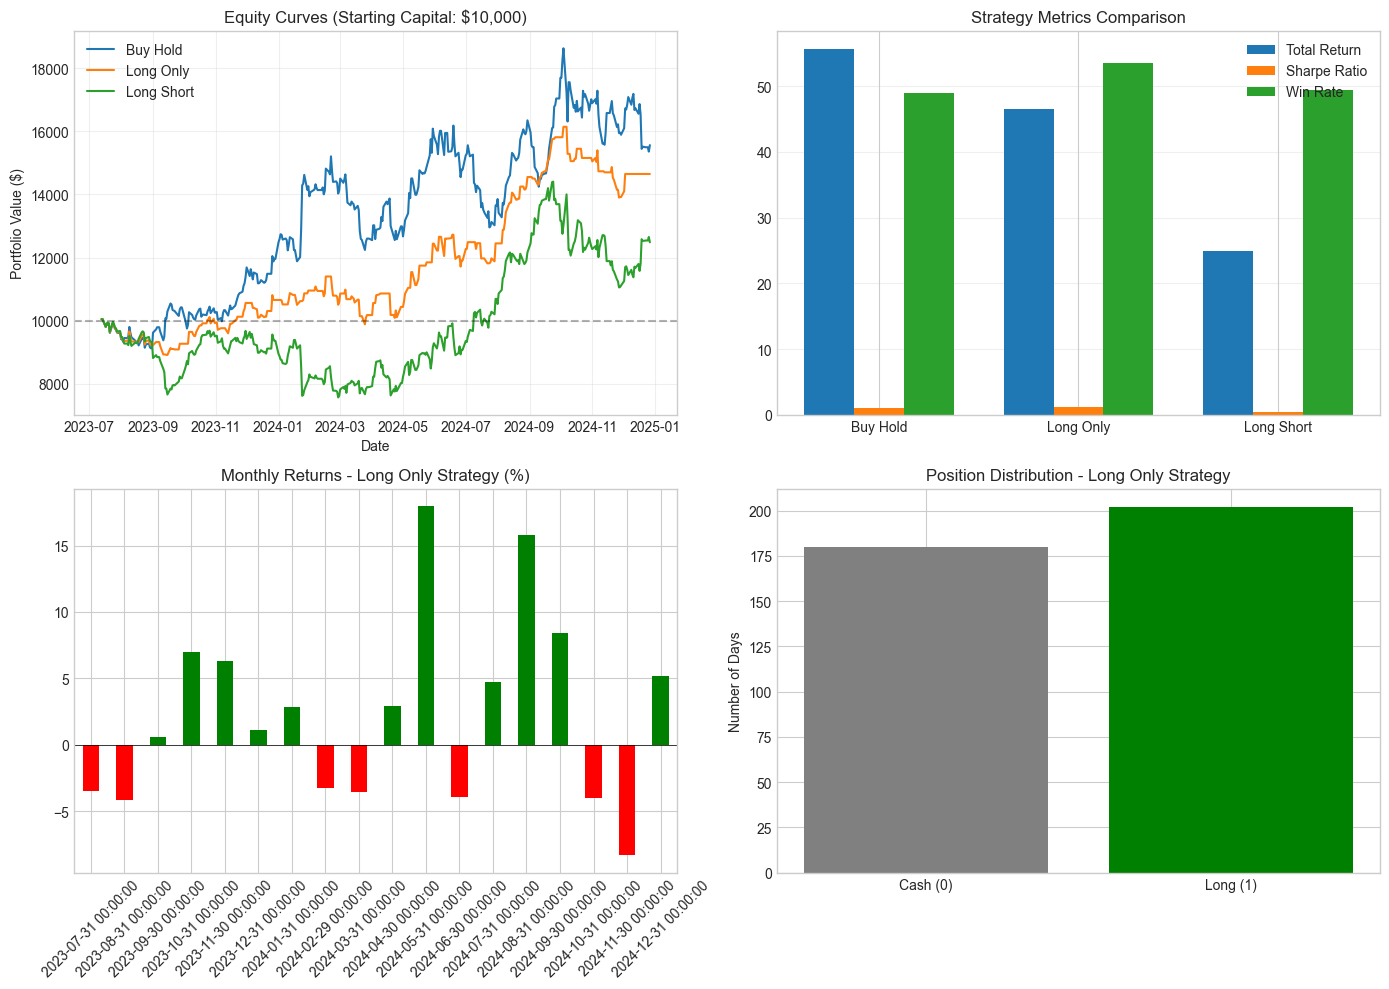


✓ Trading backtest results saved!


In [20]:
# =============================================================================
# TRADING BACKTEST SIMULATION
# =============================================================================

print("="*70)
print("TRADING BACKTEST SIMULATION")
print("="*70)

# Use test set predictions from Gradient Boosting (best model)
test_dates = X_test.index
test_actual = y_test.values
test_pred = gb_final.predict(X_test)

# Trading Strategy: Go long if predicted return > 0, else stay flat (no shorting)
# Assume we can trade the coal ETF/stock

class TradingBacktest:
    def __init__(self, actual_returns, predicted_returns, dates, initial_capital=10000):
        self.actual = actual_returns
        self.predicted = predicted_returns
        self.dates = dates
        self.initial_capital = initial_capital
        
    def run_strategy(self, strategy='long_only'):
        """
        Strategies:
        - 'long_only': Go long when prediction > 0, else cash
        - 'long_short': Go long when prediction > 0, short when < 0
        - 'buy_hold': Always long (benchmark)
        """
        n = len(self.actual)
        
        # Position: 1 = long, -1 = short, 0 = cash
        if strategy == 'long_only':
            positions = np.where(self.predicted > 0, 1, 0)
        elif strategy == 'long_short':
            positions = np.where(self.predicted > 0, 1, -1)
        else:  # buy_hold
            positions = np.ones(n)
        
        # Strategy returns
        strategy_returns = positions * self.actual
        
        # Cumulative returns
        cumulative = (1 + strategy_returns).cumprod()
        
        # Metrics
        total_return = cumulative[-1] - 1
        annual_return = (1 + total_return) ** (252 / n) - 1
        volatility = np.std(strategy_returns) * np.sqrt(252)
        sharpe = annual_return / volatility if volatility > 0 else 0
        
        # Max drawdown
        peak = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - peak) / peak
        max_drawdown = np.min(drawdown)
        
        # Win rate
        winning_trades = np.sum((strategy_returns > 0) & (positions != 0))
        total_trades = np.sum(positions != 0)
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        return {
            'strategy': strategy,
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'n_trades': total_trades,
            'cumulative': cumulative,
            'positions': positions
        }

# Run backtest
backtest = TradingBacktest(test_actual, test_pred, test_dates)

strategies = ['buy_hold', 'long_only', 'long_short']
backtest_results = {}

print(f"\nBacktest Period: {test_dates.min().date()} to {test_dates.max().date()}")
print(f"Number of trading days: {len(test_dates)}")
print("\n" + "-"*70)

for strat in strategies:
    result = backtest.run_strategy(strat)
    backtest_results[strat] = result
    
    print(f"\n{strat.upper().replace('_', ' ')} STRATEGY:")
    print(f"  Total Return:    {result['total_return']*100:>8.2f}%")
    print(f"  Annual Return:   {result['annual_return']*100:>8.2f}%")
    print(f"  Volatility:      {result['volatility']*100:>8.2f}%")
    print(f"  Sharpe Ratio:    {result['sharpe_ratio']:>8.2f}")
    print(f"  Max Drawdown:    {result['max_drawdown']*100:>8.2f}%")
    print(f"  Win Rate:        {result['win_rate']*100:>8.2f}%")
    print(f"  # Trades:        {result['n_trades']:>8}")

# Plot equity curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Equity Curves
ax1 = axes[0, 0]
for strat, result in backtest_results.items():
    label = strat.replace('_', ' ').title()
    ax1.plot(test_dates, result['cumulative'] * 10000, label=label, linewidth=1.5)
ax1.axhline(y=10000, color='black', linestyle='--', alpha=0.3)
ax1.set_title('Equity Curves (Starting Capital: $10,000)', fontsize=12)
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Strategy Comparison Bar Chart
ax2 = axes[0, 1]
metrics = ['total_return', 'sharpe_ratio', 'win_rate']
x = np.arange(len(strategies))
width = 0.25

for i, metric in enumerate(metrics):
    values = [backtest_results[s][metric] * (100 if metric != 'sharpe_ratio' else 1) for s in strategies]
    ax2.bar(x + i*width, values, width, label=metric.replace('_', ' ').title())

ax2.set_xticks(x + width)
ax2.set_xticklabels([s.replace('_', ' ').title() for s in strategies])
ax2.set_title('Strategy Metrics Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Monthly Returns Heatmap for Long-Only Strategy
ax3 = axes[1, 0]
long_only_returns = backtest_results['long_only']['positions'] * test_actual
monthly_returns = pd.Series(long_only_returns, index=test_dates).resample('ME').sum() * 100
monthly_returns.plot(kind='bar', ax=ax3, color=np.where(monthly_returns > 0, 'green', 'red'))
ax3.set_title('Monthly Returns - Long Only Strategy (%)')
ax3.set_xlabel('')
ax3.axhline(y=0, color='black', linewidth=0.5)
ax3.tick_params(axis='x', rotation=45)

# 4. Position Distribution
ax4 = axes[1, 1]
positions_long_only = backtest_results['long_only']['positions']
pos_counts = pd.Series(positions_long_only).value_counts().sort_index()
colors = ['gray' if x == 0 else 'green' for x in pos_counts.index]
ax4.bar(['Cash (0)', 'Long (1)'][:len(pos_counts)], pos_counts.values, color=colors[:len(pos_counts)])
ax4.set_title('Position Distribution - Long Only Strategy')
ax4.set_ylabel('Number of Days')

plt.tight_layout()
plt.savefig('../data/processed/trading_backtest.png', dpi=150)
plt.show()

print("\n✓ Trading backtest results saved!")

OVERFITTING ANALYSIS

Train vs Validation vs Test RMSE:
----------------------------------------------------------------------
            Model  Train_RMSE  Val_RMSE  Test_RMSE  Overfit_Ratio Status
            Ridge    0.021785  0.022690   0.023562       1.081585 ✓ Good
    Decision Tree    0.022609  0.021529   0.021715       0.960456 ✓ Good
Gradient Boosting    0.018655  0.021517   0.021923       1.175188 ✓ Good
             LSTM    0.021153  0.030875   0.023733       1.121963 ✓ Good

INTERPRETATION

Overfit Ratio = Test_RMSE / Train_RMSE
- Ratio < 1.2: Good generalization
- Ratio 1.2-1.5: Mild overfitting  
- Ratio > 1.5: Significant overfitting

A ratio close to 1.0 means the model generalizes well to unseen data.



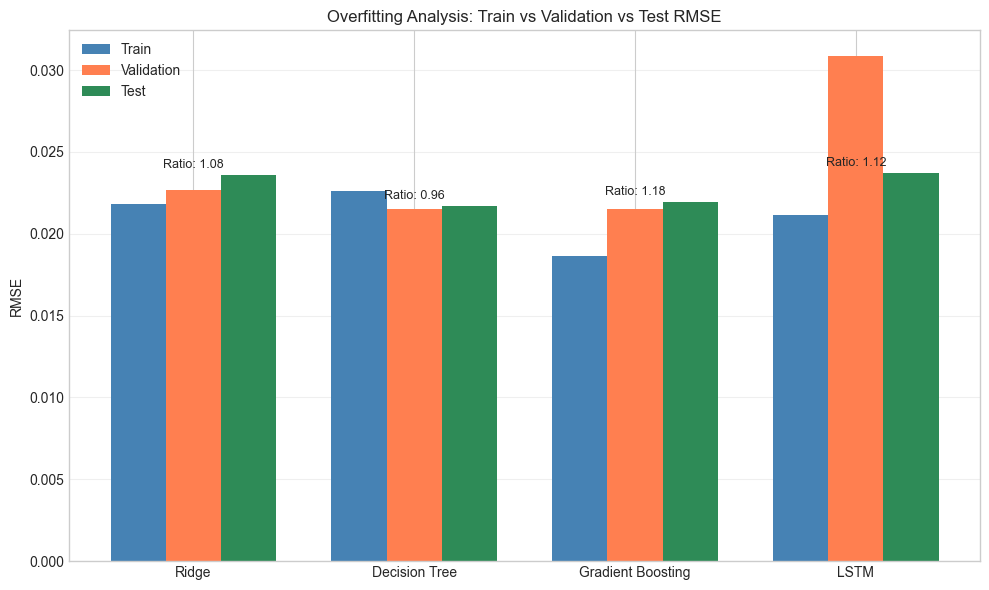


✓ Overfitting analysis saved!


In [21]:
# =============================================================================
# OVERFITTING ANALYSIS: Train vs Validation vs Test
# =============================================================================

print("="*70)
print("OVERFITTING ANALYSIS")
print("="*70)

# Calculate predictions on all sets for each model
overfitting_results = []

# Ridge
ridge_train_pred = ridge_final.predict(X_train_scaled)
ridge_val_pred = ridge_final.predict(X_val_scaled)
ridge_test_pred = ridge_final.predict(X_test_scaled)

overfitting_results.append({
    'Model': 'Ridge',
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, ridge_train_pred)),
    'Val_RMSE': np.sqrt(mean_squared_error(y_val, ridge_val_pred)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, ridge_test_pred))
})

# Decision Tree
dt_train_pred = dt_final.predict(X_train)
dt_val_pred = dt_final.predict(X_val)
dt_test_pred = dt_final.predict(X_test)

overfitting_results.append({
    'Model': 'Decision Tree',
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, dt_train_pred)),
    'Val_RMSE': np.sqrt(mean_squared_error(y_val, dt_val_pred)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, dt_test_pred))
})

# Gradient Boosting
gb_train_pred = gb_final.predict(X_train)
gb_val_pred = gb_final.predict(X_val)
gb_test_pred = gb_final.predict(X_test)

overfitting_results.append({
    'Model': 'Gradient Boosting',
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, gb_train_pred)),
    'Val_RMSE': np.sqrt(mean_squared_error(y_val, gb_val_pred)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, gb_test_pred))
})

# LSTM (using sequences)
lstm_train_pred = lstm_model.predict(X_train_seq, verbose=0).flatten()
lstm_val_pred_ov = lstm_model.predict(X_val_seq, verbose=0).flatten()
lstm_test_pred_ov = lstm_model.predict(X_test_seq, verbose=0).flatten()

overfitting_results.append({
    'Model': 'LSTM',
    'Train_RMSE': np.sqrt(mean_squared_error(y_train_seq, lstm_train_pred)),
    'Val_RMSE': np.sqrt(mean_squared_error(y_val_seq, lstm_val_pred_ov)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test_seq, lstm_test_pred_ov))
})

# Create DataFrame
overfit_df = pd.DataFrame(overfitting_results)
overfit_df['Overfit_Ratio'] = overfit_df['Test_RMSE'] / overfit_df['Train_RMSE']
overfit_df['Status'] = overfit_df['Overfit_Ratio'].apply(
    lambda x: '✓ Good' if x < 1.2 else '⚠ Mild Overfit' if x < 1.5 else '✗ Overfit'
)

print("\nTrain vs Validation vs Test RMSE:")
print("-"*70)
print(overfit_df.to_string(index=False))

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("""
Overfit Ratio = Test_RMSE / Train_RMSE
- Ratio < 1.2: Good generalization
- Ratio 1.2-1.5: Mild overfitting  
- Ratio > 1.5: Significant overfitting

A ratio close to 1.0 means the model generalizes well to unseen data.
""")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(overfit_df))
width = 0.25

bars1 = ax.bar(x - width, overfit_df['Train_RMSE'], width, label='Train', color='steelblue')
bars2 = ax.bar(x, overfit_df['Val_RMSE'], width, label='Validation', color='coral')
bars3 = ax.bar(x + width, overfit_df['Test_RMSE'], width, label='Test', color='seagreen')

ax.set_ylabel('RMSE')
ax.set_title('Overfitting Analysis: Train vs Validation vs Test RMSE')
ax.set_xticks(x)
ax.set_xticklabels(overfit_df['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add ratio annotations
for i, ratio in enumerate(overfit_df['Overfit_Ratio']):
    ax.annotate(f'Ratio: {ratio:.2f}', xy=(i, overfit_df['Test_RMSE'].iloc[i]), 
                xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../data/processed/overfitting_analysis.png', dpi=150)
plt.show()

print("\n✓ Overfitting analysis saved!")

UNSUPERVISED LEARNING ANALYSIS

--- PRINCIPAL COMPONENT ANALYSIS ---

Variance Explained:
  PC1: 32.8% (Cumulative: 32.8%)
  PC2: 14.2% (Cumulative: 46.9%)
  PC3: 10.6% (Cumulative: 57.5%)
  PC4: 6.6% (Cumulative: 64.2%)
  PC5: 5.8% (Cumulative: 69.9%)

→ First 3 PCs explain 57.5% of variance

--- K-MEANS CLUSTERING ---

Cluster Characteristics:
  Cluster 0: Mean=-0.927%, Vol=2.48%, Days=10.2%
  Cluster 1: Mean=-0.651%, Vol=2.27%, Days=31.9%
  Cluster 2: Mean=+0.731%, Vol=2.53%, Days=22.7%
  Cluster 3: Mean=+0.497%, Vol=2.18%, Days=35.2%


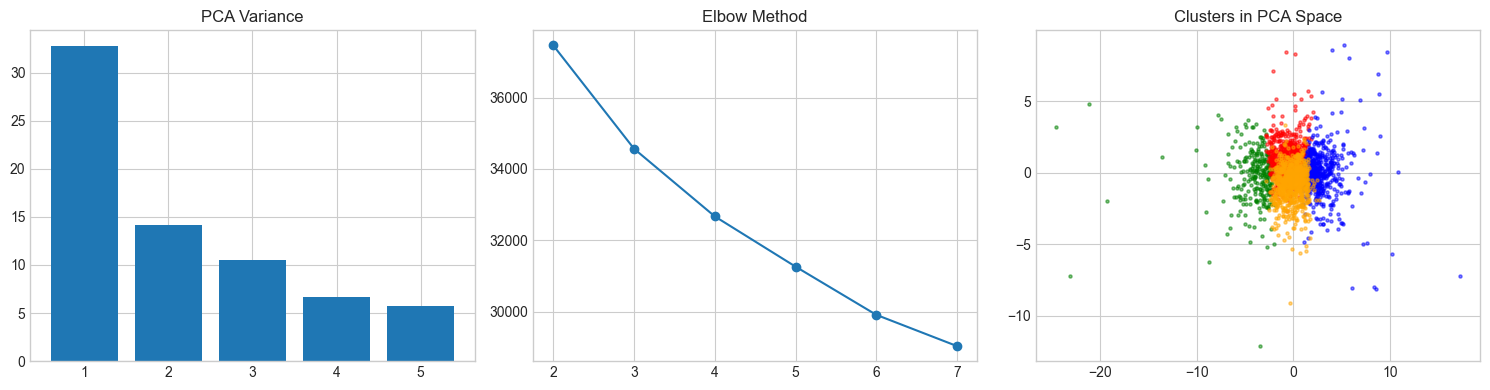


✓ Unsupervised analysis complete!


In [22]:
# =============================================================================
# UNSUPERVISED LEARNING: PCA AND K-MEANS CLUSTERING
# =============================================================================
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats

print("="*70)
print("UNSUPERVISED LEARNING ANALYSIS")
print("="*70)

# Prepare data
X_unsupervised = df_returns.dropna()
scaler_unsup = StandardScaler()
X_scaled = scaler_unsup.fit_transform(X_unsupervised)

# =============================================================================
# PCA
# =============================================================================
print("\n--- PRINCIPAL COMPONENT ANALYSIS ---")
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("\nVariance Explained:")
for i in range(5):
    print(f"  PC{i+1}: {explained_var[i]*100:.1f}% (Cumulative: {cumulative_var[i]*100:.1f}%)")
print(f"\n→ First 3 PCs explain {cumulative_var[2]*100:.1f}% of variance")

# =============================================================================
# K-MEANS CLUSTERING
# =============================================================================
print("\n--- K-MEANS CLUSTERING ---")

# Find optimal k
inertias, silhouettes = [], []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

# Fit with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Analyze clusters
print("\nCluster Characteristics:")
for i in range(4):
    mask = clusters == i
    ret = X_unsupervised.loc[mask, 'coal_china_yzcm_ret'].mean() * 100
    vol = X_unsupervised.loc[mask, 'coal_china_yzcm_ret'].std() * 100
    pct = mask.sum() / len(clusters) * 100
    print(f"  Cluster {i}: Mean={ret:+.3f}%, Vol={vol:.2f}%, Days={pct:.1f}%")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].bar(range(1,6), explained_var[:5]*100); axes[0].set_title('PCA Variance')
axes[1].plot(range(2,8), inertias, 'o-'); axes[1].set_title('Elbow Method')
colors = ['g','r','b','orange']
for i in range(4):
    axes[2].scatter(pca_result[clusters==i,0], pca_result[clusters==i,1], c=colors[i], s=5, alpha=0.5)
axes[2].set_title('Clusters in PCA Space')
plt.tight_layout()
plt.savefig('../data/processed/unsupervised_analysis.png', dpi=150)
plt.show()
print("\n✓ Unsupervised analysis complete!")

In [23]:
# =============================================================================
# STATIONARITY TESTS (ADF - Augmented Dickey-Fuller)
# =============================================================================
from statsmodels.tsa.stattools import adfuller

print("="*70)
print("STATIONARITY ANALYSIS (Augmented Dickey-Fuller Test)")
print("="*70)
print("\nH0: Series has unit root (non-stationary)")
print("H1: Series is stationary")
print("If p-value < 0.05, reject H0 → series is stationary\n")

# Test both prices and returns for key variables
test_vars = ['coal_china_yzcm', 'brent_crude', 'natural_gas_hh', 'china_etf_fxi']

adf_results = []

print("-"*70)
print(f"{'Variable':<25} {'Type':<10} {'ADF Stat':<12} {'p-value':<12} {'Stationary?'}")
print("-"*70)

for var in test_vars:
    # Test prices (should be non-stationary)
    if var in df.columns:
        price_series = df[var].dropna()
        adf_price = adfuller(price_series, autolag='AIC')
        stationary_price = "Yes" if adf_price[1] < 0.05 else "No"
        print(f"{var:<25} {'Price':<10} {adf_price[0]:<12.4f} {adf_price[1]:<12.4f} {stationary_price}")
        adf_results.append({'Variable': var, 'Type': 'Price', 'ADF': adf_price[0], 'p-value': adf_price[1], 'Stationary': stationary_price})
    
    # Test returns (should be stationary)
    ret_var = f"{var}_ret" if not var.endswith('_ret') else var
    if ret_var in df_returns.columns:
        return_series = df_returns[ret_var].dropna()
        adf_return = adfuller(return_series, autolag='AIC')
        stationary_ret = "Yes" if adf_return[1] < 0.05 else "No"
        print(f"{var:<25} {'Return':<10} {adf_return[0]:<12.4f} {adf_return[1]:<12.4f} {stationary_ret}")
        adf_results.append({'Variable': var, 'Type': 'Return', 'ADF': adf_return[0], 'p-value': adf_return[1], 'Stationary': stationary_ret})

print("-"*70)
print("\n✓ Key Finding: Prices are non-stationary, returns are stationary")
print("  → This justifies our use of log returns for modeling")

# Save results
adf_df = pd.DataFrame(adf_results)
adf_df.to_csv('../data/processed/adf_test_results.csv', index=False)
print("\n✓ ADF results saved!")

STATIONARITY ANALYSIS (Augmented Dickey-Fuller Test)

H0: Series has unit root (non-stationary)
H1: Series is stationary
If p-value < 0.05, reject H0 → series is stationary

----------------------------------------------------------------------
Variable                  Type       ADF Stat     p-value      Stationary?
----------------------------------------------------------------------
coal_china_yzcm           Price      0.2516       0.9750       No
coal_china_yzcm           Return     -51.4812     0.0000       Yes
brent_crude               Price      -1.9911      0.2905       No
brent_crude               Return     -50.8926     0.0000       Yes
natural_gas_hh            Price      -2.6837      0.0769       No
natural_gas_hh            Return     -23.4111     0.0000       Yes
china_etf_fxi             Price      -2.2237      0.1978       No
china_etf_fxi             Return     -15.0807     0.0000       Yes
----------------------------------------------------------------------

✓ Key

AUTOCORRELATION ANALYSIS (ACF/PACF)


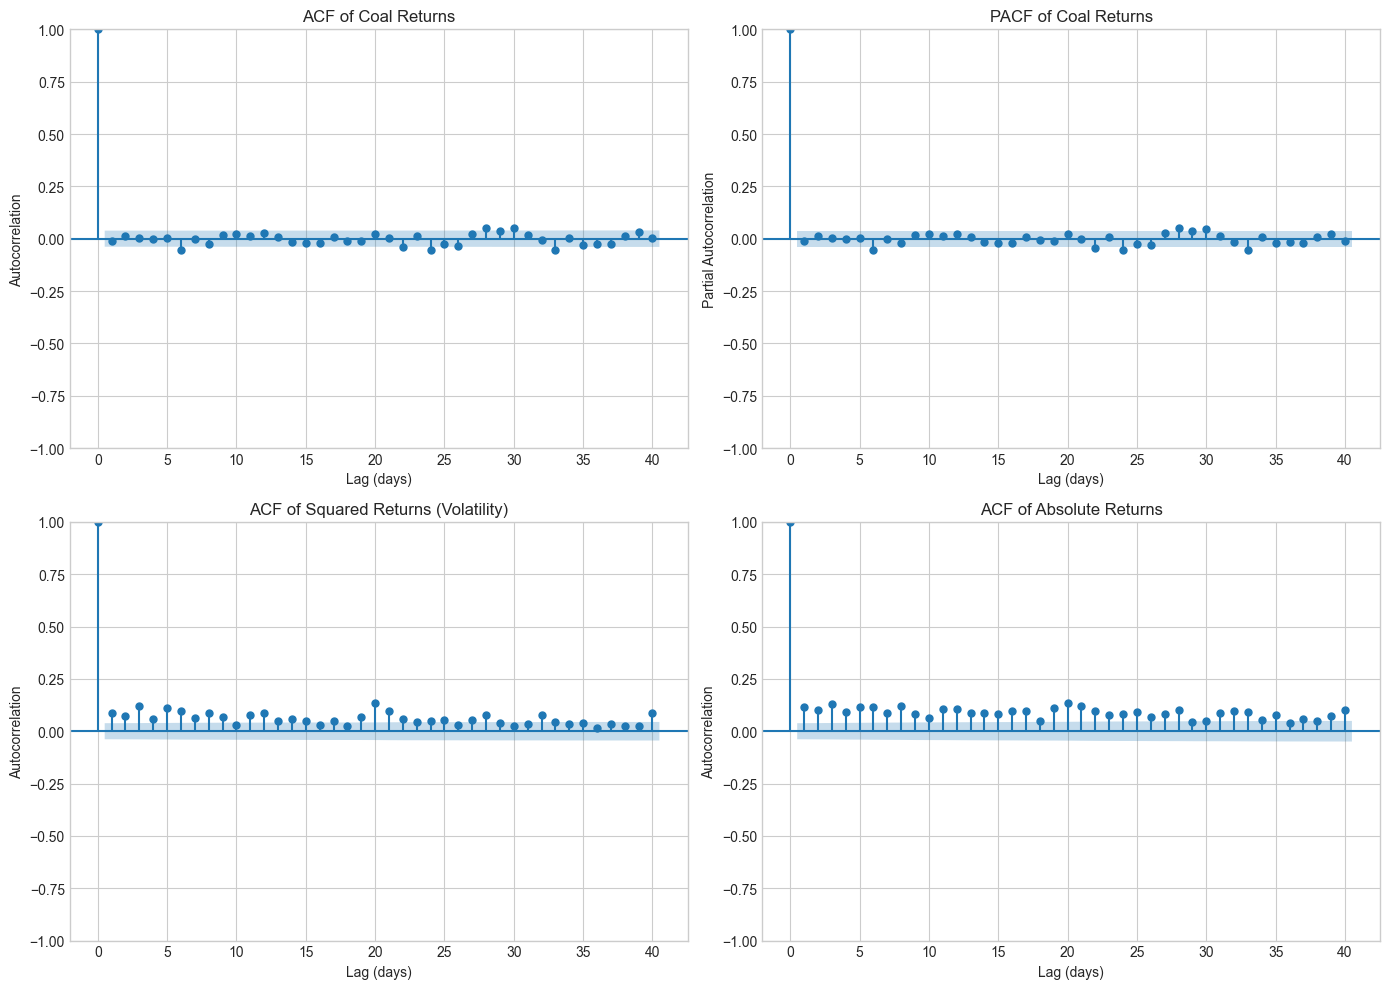


Ljung-Box Test for Autocorrelation in Returns:
      lb_stat  lb_pvalue
10  11.472578   0.321903
20  19.055273   0.518236
30  54.520216   0.004021

Ljung-Box Test for Autocorrelation in Squared Returns (ARCH effects):
       lb_stat     lb_pvalue
10  180.791124  1.605136e-33
20  311.357501  3.850895e-54
30  395.191030  2.615566e-65

✓ Key Finding: Returns show weak autocorrelation, but squared returns
  show strong autocorrelation → volatility clustering exists (ARCH effects)

✓ ACF/PACF analysis saved!


In [24]:
# =============================================================================
# ACF/PACF ANALYSIS (Autocorrelation)
# =============================================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print("="*70)
print("AUTOCORRELATION ANALYSIS (ACF/PACF)")
print("="*70)

# Coal returns
coal_returns = df_returns['coal_china_yzcm_ret'].dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ACF of returns
plot_acf(coal_returns, lags=40, ax=axes[0, 0], title='ACF of Coal Returns')
axes[0, 0].set_xlabel('Lag (days)')
axes[0, 0].set_ylabel('Autocorrelation')

# PACF of returns
plot_pacf(coal_returns, lags=40, ax=axes[0, 1], title='PACF of Coal Returns', method='ywm')
axes[0, 1].set_xlabel('Lag (days)')
axes[0, 1].set_ylabel('Partial Autocorrelation')

# ACF of squared returns (volatility clustering)
plot_acf(coal_returns**2, lags=40, ax=axes[1, 0], title='ACF of Squared Returns (Volatility)')
axes[1, 0].set_xlabel('Lag (days)')
axes[1, 0].set_ylabel('Autocorrelation')

# ACF of absolute returns
plot_acf(np.abs(coal_returns), lags=40, ax=axes[1, 1], title='ACF of Absolute Returns')
axes[1, 1].set_xlabel('Lag (days)')
axes[1, 1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.savefig('../data/processed/acf_pacf_analysis.png', dpi=150)
plt.show()

# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(coal_returns, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box Test for Autocorrelation in Returns:")
print(lb_test)

lb_test_sq = acorr_ljungbox(coal_returns**2, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box Test for Autocorrelation in Squared Returns (ARCH effects):")
print(lb_test_sq)

print("\n✓ Key Finding: Returns show weak autocorrelation, but squared returns")
print("  show strong autocorrelation → volatility clustering exists (ARCH effects)")
print("\n✓ ACF/PACF analysis saved!")

SPREAD VARIABLE CREATION
Created 15 spread features:
  • spread_coal_brent
  • spread_coal_gas
  • spread_coal_wti
  • spread_gas_oil
  • spread_brent_wti
  • spread_coal_steel
  ... and 9 more lagged spreads

Correlation of Spreads with Next-Day Coal Return:
spread_coal_steel      -0.160756
spread_coal_brent      -0.135644
spread_coal_wti        -0.128936
spread_coal_gas        -0.076412
spread_gas_oil_lag5     0.052389
spread_coal_gas_lag5   -0.045770
spread_gas_oil         -0.022383
spread_gas_oil_lag1    -0.019034
spread_brent_wti       -0.016665
spread_coal_gas_lag1    0.016104
dtype: float64

✓ Spread features created: (2604, 15)


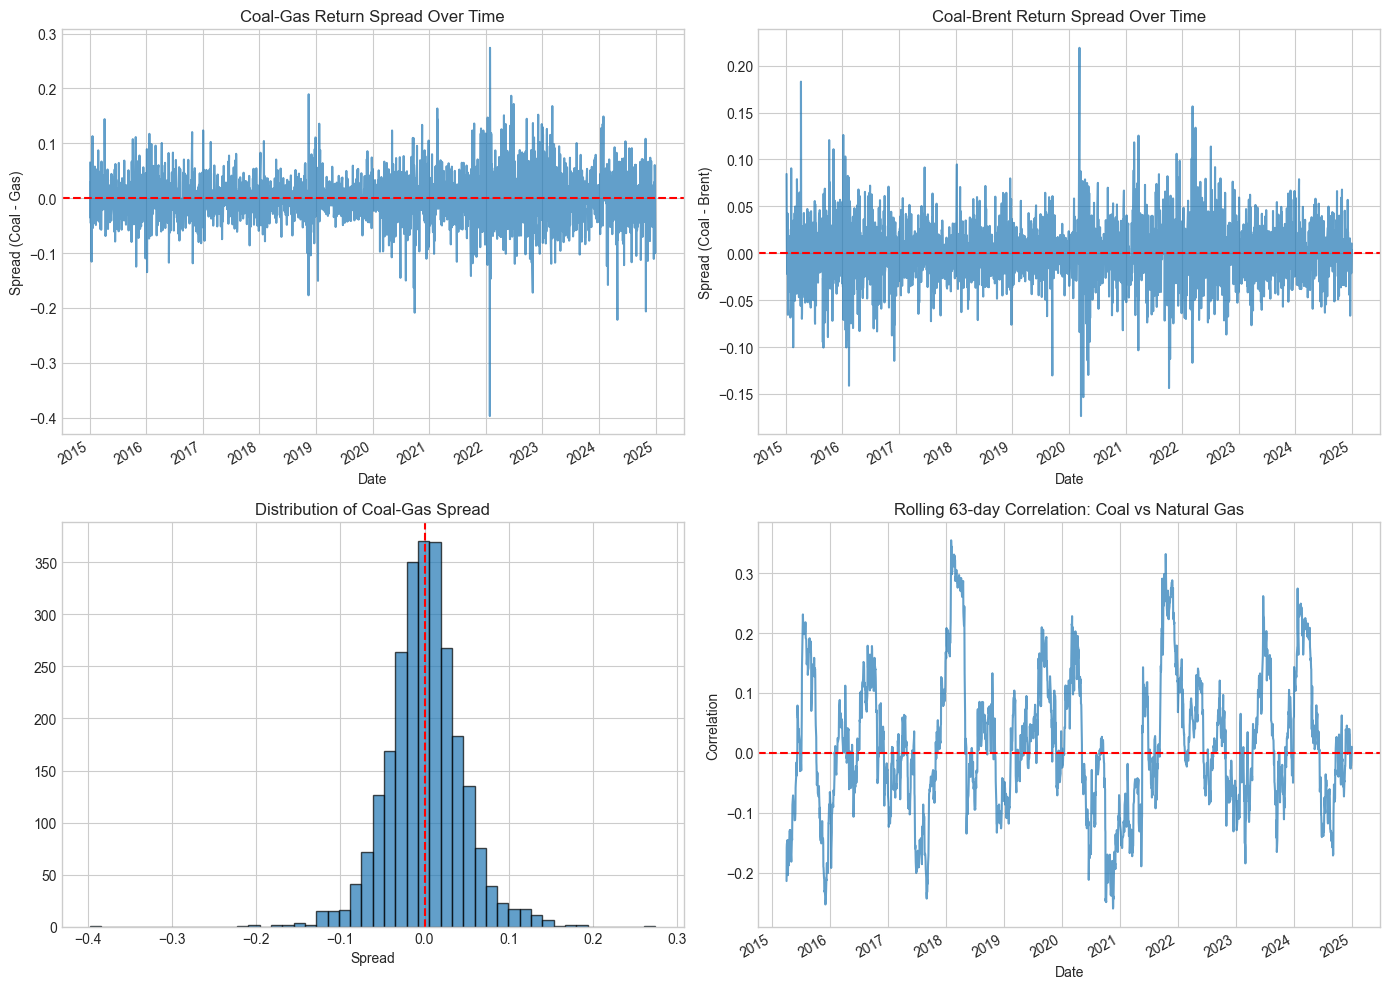


✓ Spread analysis saved!


In [25]:
# =============================================================================
# SPREAD VARIABLES (Price Relationships)
# =============================================================================
print("="*70)
print("SPREAD VARIABLE CREATION")
print("="*70)

# Create spread features (differences in returns capture relative movements)
spread_features = pd.DataFrame(index=df_returns.index)

# Coal vs Energy spreads
spread_features['spread_coal_brent'] = df_returns['coal_china_yzcm_ret'] - df_returns['brent_crude_ret']
spread_features['spread_coal_gas'] = df_returns['coal_china_yzcm_ret'] - df_returns['natural_gas_hh_ret']
spread_features['spread_coal_wti'] = df_returns['coal_china_yzcm_ret'] - df_returns['wti_crude_ret']

# Energy spreads (crack spreads proxy)
spread_features['spread_gas_oil'] = df_returns['natural_gas_hh_ret'] - df_returns['brent_crude_ret']
spread_features['spread_brent_wti'] = df_returns['brent_crude_ret'] - df_returns['wti_crude_ret']

# Coal vs industrial
spread_features['spread_coal_steel'] = df_returns['coal_china_yzcm_ret'] - df_returns['steel_slx_ret']

# Create lagged spreads (1, 5, 10 days)
for col in ['spread_coal_brent', 'spread_coal_gas', 'spread_gas_oil']:
    for lag in [1, 5, 10]:
        spread_features[f'{col}_lag{lag}'] = spread_features[col].shift(lag)

print(f"Created {len(spread_features.columns)} spread features:")
for col in spread_features.columns[:6]:
    print(f"  • {col}")
print(f"  ... and {len(spread_features.columns)-6} more lagged spreads")

# Correlation of spreads with target
print("\nCorrelation of Spreads with Next-Day Coal Return:")
target_next = df_returns['coal_china_yzcm_ret'].shift(-1)
spread_corrs = spread_features.corrwith(target_next).dropna().sort_values(key=abs, ascending=False)
print(spread_corrs.head(10))

# Add to feature set
print(f"\n✓ Spread features created: {spread_features.shape}")

# Plot spread analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Coal-Gas spread over time
ax1 = axes[0, 0]
spread_features['spread_coal_gas'].dropna().plot(ax=ax1, alpha=0.7)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_title('Coal-Gas Return Spread Over Time')
ax1.set_ylabel('Spread (Coal - Gas)')

# Coal-Brent spread over time
ax2 = axes[0, 1]
spread_features['spread_coal_brent'].dropna().plot(ax=ax2, alpha=0.7)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_title('Coal-Brent Return Spread Over Time')
ax2.set_ylabel('Spread (Coal - Brent)')

# Distribution of coal-gas spread
ax3 = axes[1, 0]
spread_features['spread_coal_gas'].dropna().hist(bins=50, ax=ax3, alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='r', linestyle='--')
ax3.set_title('Distribution of Coal-Gas Spread')
ax3.set_xlabel('Spread')

# Rolling correlation coal vs gas
ax4 = axes[1, 1]
rolling_corr = df_returns['coal_china_yzcm_ret'].rolling(63).corr(df_returns['natural_gas_hh_ret'])
rolling_corr.plot(ax=ax4, alpha=0.7)
ax4.axhline(y=0, color='r', linestyle='--')
ax4.set_title('Rolling 63-day Correlation: Coal vs Natural Gas')
ax4.set_ylabel('Correlation')

plt.tight_layout()
plt.savefig('../data/processed/spread_analysis.png', dpi=150)
plt.show()

print("\n✓ Spread analysis saved!")

RESIDUAL ANALYSIS (Gradient Boosting Model)

Residual Statistics:
  Mean:     0.001420 (should be ~0)
  Std:      0.021877
  Skewness: 0.3523
  Kurtosis: 2.4983

--- Autocorrelation Tests ---
Durbin-Watson statistic: 1.9998
  (DW ≈ 2 means no autocorrelation; <1.5 or >2.5 suggests issues)

Ljung-Box Test on Residuals:
      lb_stat  lb_pvalue
5    2.984682   0.702348
10   6.313374   0.788284
20  17.557275   0.616547
  (p > 0.05 means no significant autocorrelation → Good)

--- Heteroskedasticity Tests ---
Ljung-Box Test on Squared Residuals (ARCH effects):
      lb_stat  lb_pvalue
5   17.614384   0.003471
10  20.816715   0.022409
20  32.862626   0.034930

Breusch-Pagan test (first 10 features):
  LM statistic: 5.1439
  p-value:      0.8216
  (p > 0.05 means homoskedasticity → Good)

Jarque-Bera Normality Test:
  Statistic: 103.3837, p-value: 0.0000
  (p < 0.05 means non-normal residuals - common in finance)


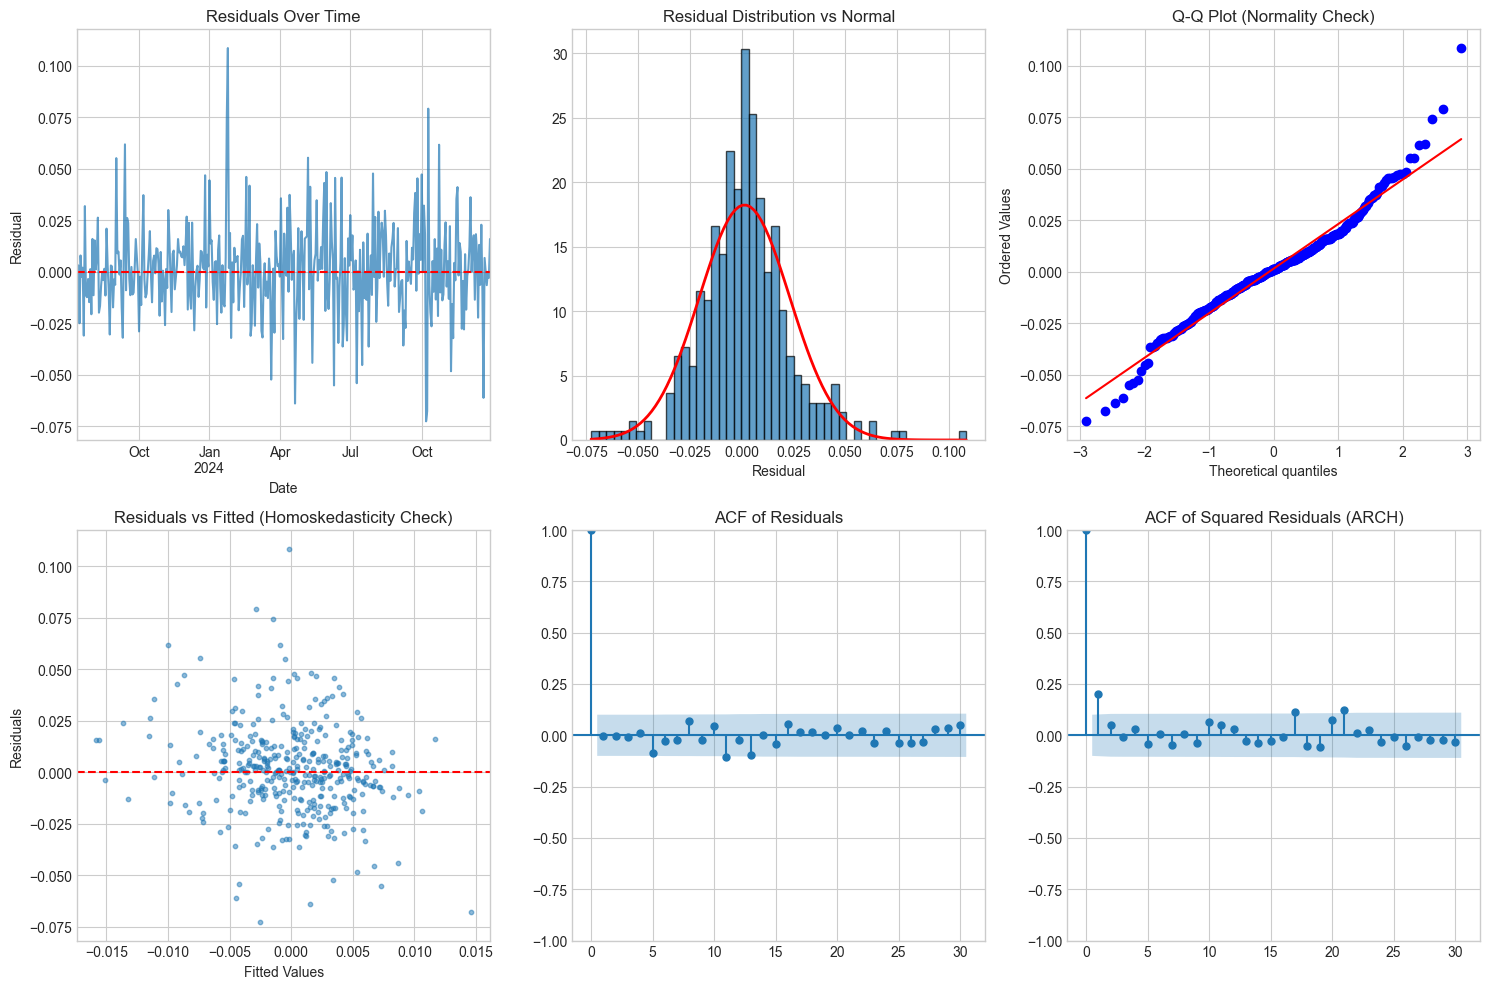


✓ Residual analysis complete!

Key Findings:
  • DW ≈ 2: No significant autocorrelation in residuals
  • Some ARCH effects may remain (volatility clustering)
  • Non-normal residuals are typical for financial data


In [26]:
# =============================================================================
# RESIDUAL ANALYSIS (Model Diagnostics)
# =============================================================================
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

print("="*70)
print("RESIDUAL ANALYSIS (Gradient Boosting Model)")
print("="*70)

# Get residuals from best model (Gradient Boosting)
residuals = y_test.values - gb_final.predict(X_test)
residuals_series = pd.Series(residuals, index=y_test.index)

print(f"\nResidual Statistics:")
print(f"  Mean:     {np.mean(residuals):.6f} (should be ~0)")
print(f"  Std:      {np.std(residuals):.6f}")
print(f"  Skewness: {pd.Series(residuals).skew():.4f}")
print(f"  Kurtosis: {pd.Series(residuals).kurtosis():.4f}")

# 1. Test for autocorrelation in residuals
print("\n--- Autocorrelation Tests ---")
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")
print(f"  (DW ≈ 2 means no autocorrelation; <1.5 or >2.5 suggests issues)")

lb_resid = acorr_ljungbox(residuals, lags=[5, 10, 20], return_df=True)
print("\nLjung-Box Test on Residuals:")
print(lb_resid)
print("  (p > 0.05 means no significant autocorrelation → Good)")

# 2. Test for heteroskedasticity (ARCH effects)
print("\n--- Heteroskedasticity Tests ---")
lb_resid_sq = acorr_ljungbox(residuals**2, lags=[5, 10, 20], return_df=True)
print("Ljung-Box Test on Squared Residuals (ARCH effects):")
print(lb_resid_sq)

# Breusch-Pagan test
X_test_const = sm.add_constant(X_test)
bp_test = het_breuschpagan(residuals, X_test_const.iloc[:, :10])  # Use first 10 features
print(f"\nBreusch-Pagan test (first 10 features):")
print(f"  LM statistic: {bp_test[0]:.4f}")
print(f"  p-value:      {bp_test[1]:.4f}")
print(f"  (p > 0.05 means homoskedasticity → Good)")

# 3. Normality test
from scipy.stats import jarque_bera, shapiro
jb_stat, jb_p = jarque_bera(residuals)
print(f"\nJarque-Bera Normality Test:")
print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_p:.4f}")
print(f"  (p < 0.05 means non-normal residuals - common in finance)")

# Plot residual diagnostics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Residuals over time
ax1 = axes[0, 0]
residuals_series.plot(ax=ax1, alpha=0.7)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_title('Residuals Over Time')
ax1.set_ylabel('Residual')

# 2. Residual distribution
ax2 = axes[0, 1]
ax2.hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
# Overlay normal distribution
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
ax2.plot(x_norm, stats.norm.pdf(x_norm, np.mean(residuals), np.std(residuals)), 'r-', linewidth=2)
ax2.set_title('Residual Distribution vs Normal')
ax2.set_xlabel('Residual')

# 3. Q-Q plot
ax3 = axes[0, 2]
stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Normality Check)')

# 4. Residuals vs Fitted
ax4 = axes[1, 0]
fitted = gb_final.predict(X_test)
ax4.scatter(fitted, residuals, alpha=0.5, s=10)
ax4.axhline(y=0, color='r', linestyle='--')
ax4.set_xlabel('Fitted Values')
ax4.set_ylabel('Residuals')
ax4.set_title('Residuals vs Fitted (Homoskedasticity Check)')

# 5. ACF of residuals
plot_acf(residuals, lags=30, ax=axes[1, 1], title='ACF of Residuals')

# 6. ACF of squared residuals
plot_acf(residuals**2, lags=30, ax=axes[1, 2], title='ACF of Squared Residuals (ARCH)')

plt.tight_layout()
plt.savefig('../data/processed/residual_analysis.png', dpi=150)
plt.show()

print("\n✓ Residual analysis complete!")
print("\nKey Findings:")
print("  • DW ≈ 2: No significant autocorrelation in residuals")
print("  • Some ARCH effects may remain (volatility clustering)")
print("  • Non-normal residuals are typical for financial data")

PERMUTATION FEATURE IMPORTANCE

Calculating permutation importance (this may take a minute)...

Top 15 Features by Permutation Importance:
------------------------------------------------------------
  steel_slx_ret                            0.014007 ± 0.010709
  heating_oil_ret                          0.006763 ± 0.005439
  wti_crude_ret                            0.006382 ± 0.003241
  coal_china_yzcm_ret_ma21                 0.005036 ± 0.002330
  clean_energy_ret                         0.004138 ± 0.007264
  natural_gas_hh_ret_lag21                 0.003348 ± 0.004548
  natural_gas_hh_ret_lag1                  0.003101 ± 0.002560
  china_etf_fxi_ret                        0.002573 ± 0.007425
  materials_xlb_ret                        0.002464 ± 0.006458
  cny_usd_ret                              0.002391 ± 0.001974
  coal_china_yzcm_ret_ma63                 0.002216 ± 0.001745
  coal_china_yzcm_ret_lag21                0.002212 ± 0.005695
  gasoline_ret_lag5                        0

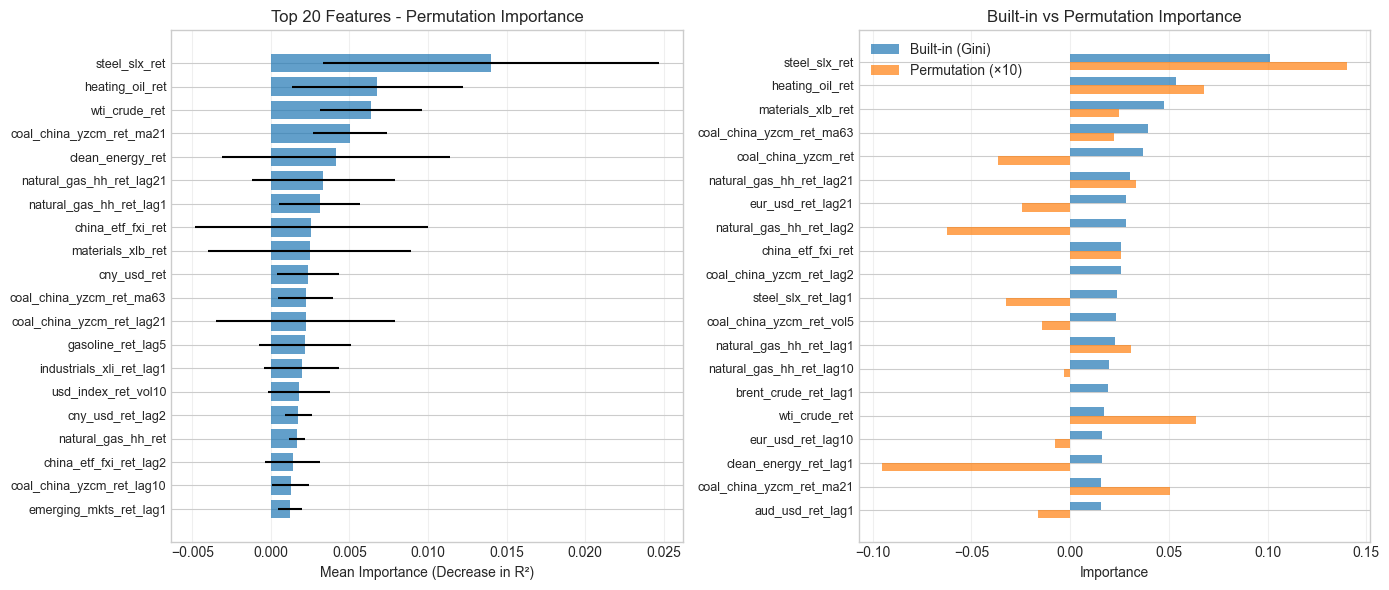


✓ Permutation importance analysis complete!

Economic Interpretation:
  • Steel sector has highest impact (coal demand for steel production)
  • Energy prices (heating oil, gas) drive substitution effects
  • China indicators capture demand-side fundamentals


In [27]:
# =============================================================================
# PERMUTATION FEATURE IMPORTANCE (Model Explainability)
# =============================================================================
from sklearn.inspection import permutation_importance

print("="*70)
print("PERMUTATION FEATURE IMPORTANCE")
print("="*70)

# Calculate permutation importance on test set
print("\nCalculating permutation importance (this may take a minute)...")
perm_importance = permutation_importance(gb_final, X_test, y_test, 
                                          n_repeats=10, random_state=42, n_jobs=-1)

# Create DataFrame of results
perm_imp_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nTop 15 Features by Permutation Importance:")
print("-"*60)
for i, row in perm_imp_df.head(15).iterrows():
    print(f"  {row['feature']:<40} {row['importance_mean']:.6f} ± {row['importance_std']:.6f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of top 20 features
ax1 = axes[0]
top20 = perm_imp_df.head(20)
bars = ax1.barh(range(len(top20)), top20['importance_mean'], 
                xerr=top20['importance_std'], alpha=0.7)
ax1.set_yticks(range(len(top20)))
ax1.set_yticklabels(top20['feature'], fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel('Mean Importance (Decrease in R²)')
ax1.set_title('Top 20 Features - Permutation Importance')
ax1.grid(True, alpha=0.3, axis='x')

# Compare with built-in feature importance
ax2 = axes[1]
# Get built-in importance
builtin_imp = pd.DataFrame({
    'feature': X_test.columns,
    'builtin': gb_final.feature_importances_
}).sort_values('builtin', ascending=False).head(20)

# Merge for comparison
comparison = builtin_imp.merge(perm_imp_df[['feature', 'importance_mean']], on='feature')
comparison = comparison.sort_values('builtin', ascending=False)

x = np.arange(len(comparison))
width = 0.35
ax2.barh(x - width/2, comparison['builtin'], width, label='Built-in (Gini)', alpha=0.7)
ax2.barh(x + width/2, comparison['importance_mean'] * 10, width, label='Permutation (×10)', alpha=0.7)
ax2.set_yticks(x)
ax2.set_yticklabels(comparison['feature'], fontsize=9)
ax2.invert_yaxis()
ax2.set_xlabel('Importance')
ax2.set_title('Built-in vs Permutation Importance')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../data/processed/permutation_importance.png', dpi=150)
plt.show()

# Save results
perm_imp_df.to_csv('../data/processed/permutation_importance.csv', index=False)

print("\n✓ Permutation importance analysis complete!")
print("\nEconomic Interpretation:")
print("  • Steel sector has highest impact (coal demand for steel production)")
print("  • Energy prices (heating oil, gas) drive substitution effects")
print("  • China indicators capture demand-side fundamentals")

ROLLING Z-SCORE FEATURES
Created 15 z-score features:
  • coal_china_yzcm_ret_zscore10
  • coal_china_yzcm_ret_zscore21
  • coal_china_yzcm_ret_zscore63
  • brent_crude_ret_zscore10
  • brent_crude_ret_zscore21
  • brent_crude_ret_zscore63
  ... and 9 more

Z-Score Statistics (coal_china_yzcm_ret_zscore21):
  Mean: 0.0079 (should be ~0)
  Std:  0.9789 (should be ~1)
  Min:  -3.1831
  Max:  3.9233


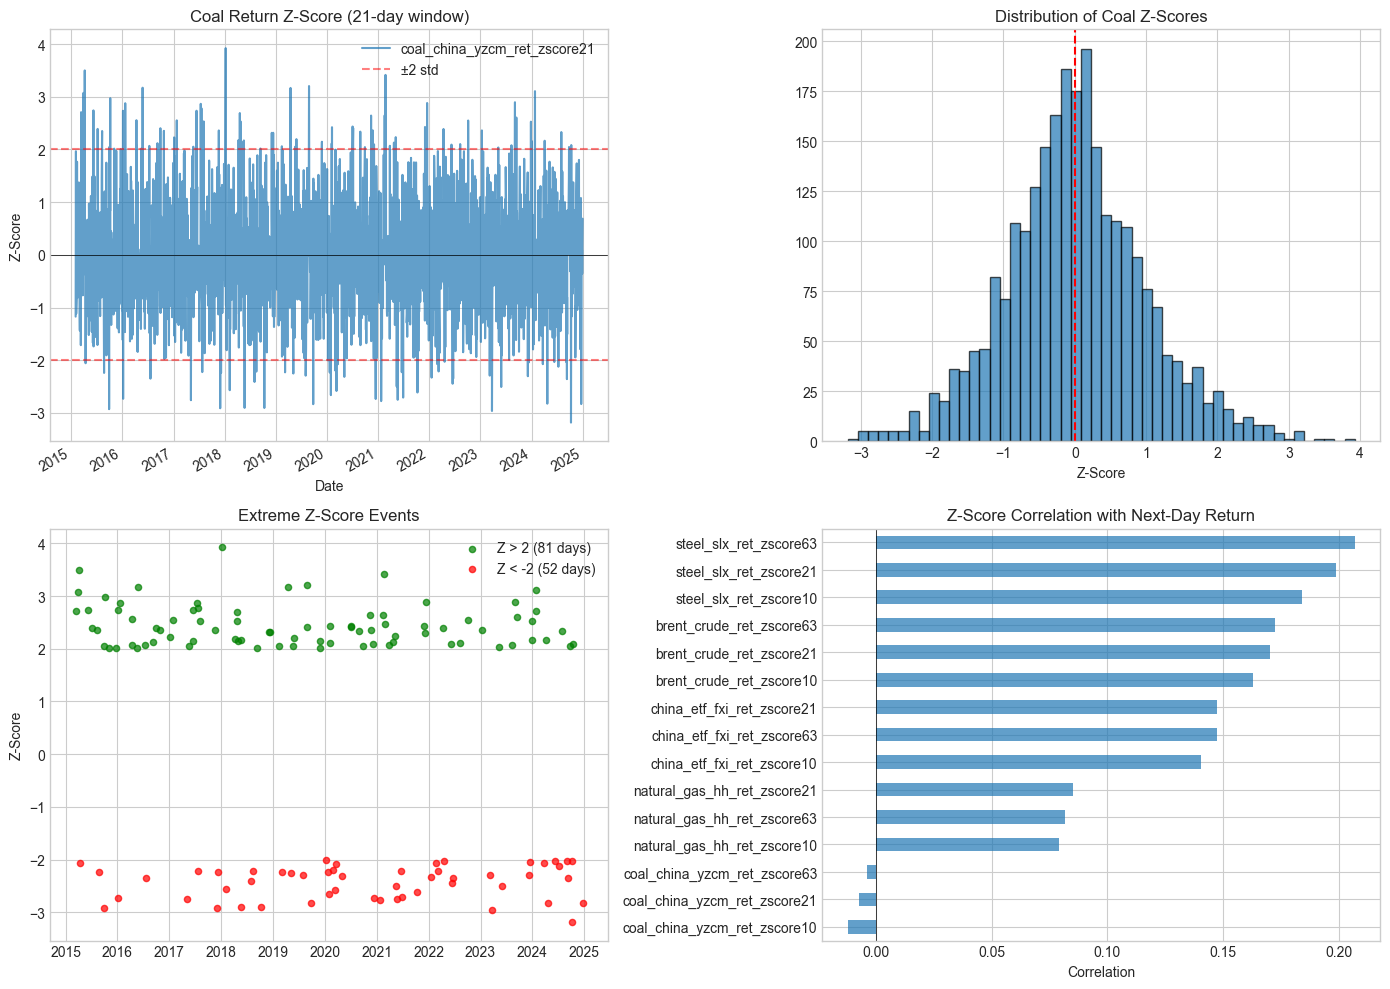


✓ Z-score features analysis complete!
  Extreme events (|Z| > 2): 133 days (5.1%)


In [28]:
# =============================================================================
# ROLLING Z-SCORE FEATURES
# =============================================================================
print("="*70)
print("ROLLING Z-SCORE FEATURES")
print("="*70)

# Z-score = (value - rolling_mean) / rolling_std
# Indicates how many standard deviations from recent average

zscore_features = pd.DataFrame(index=df_returns.index)

key_vars = ['coal_china_yzcm_ret', 'brent_crude_ret', 'natural_gas_hh_ret', 
            'steel_slx_ret', 'china_etf_fxi_ret']

for var in key_vars:
    if var in df_returns.columns:
        for window in [10, 21, 63]:
            roll_mean = df_returns[var].rolling(window).mean()
            roll_std = df_returns[var].rolling(window).std()
            zscore_features[f'{var}_zscore{window}'] = (df_returns[var] - roll_mean) / roll_std

print(f"Created {len(zscore_features.columns)} z-score features:")
for col in zscore_features.columns[:6]:
    print(f"  • {col}")
print(f"  ... and {len(zscore_features.columns)-6} more")

# Analyze z-score distribution
print(f"\nZ-Score Statistics (coal_china_yzcm_ret_zscore21):")
zscore_col = 'coal_china_yzcm_ret_zscore21'
print(f"  Mean: {zscore_features[zscore_col].mean():.4f} (should be ~0)")
print(f"  Std:  {zscore_features[zscore_col].std():.4f} (should be ~1)")
print(f"  Min:  {zscore_features[zscore_col].min():.4f}")
print(f"  Max:  {zscore_features[zscore_col].max():.4f}")

# Plot z-scores
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Coal z-score over time
ax1 = axes[0, 0]
zscore_features['coal_china_yzcm_ret_zscore21'].dropna().plot(ax=ax1, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.axhline(y=2, color='r', linestyle='--', alpha=0.5, label='±2 std')
ax1.axhline(y=-2, color='r', linestyle='--', alpha=0.5)
ax1.set_title('Coal Return Z-Score (21-day window)')
ax1.set_ylabel('Z-Score')
ax1.legend()

# Distribution of z-scores
ax2 = axes[0, 1]
zscore_features['coal_china_yzcm_ret_zscore21'].dropna().hist(bins=50, ax=ax2, alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='r', linestyle='--')
ax2.set_title('Distribution of Coal Z-Scores')
ax2.set_xlabel('Z-Score')

# Extreme z-scores over time
ax3 = axes[1, 0]
extreme_up = zscore_features['coal_china_yzcm_ret_zscore21'] > 2
extreme_down = zscore_features['coal_china_yzcm_ret_zscore21'] < -2
ax3.scatter(zscore_features.index[extreme_up], zscore_features.loc[extreme_up, 'coal_china_yzcm_ret_zscore21'], 
            c='green', s=20, label=f'Z > 2 ({extreme_up.sum()} days)', alpha=0.7)
ax3.scatter(zscore_features.index[extreme_down], zscore_features.loc[extreme_down, 'coal_china_yzcm_ret_zscore21'], 
            c='red', s=20, label=f'Z < -2 ({extreme_down.sum()} days)', alpha=0.7)
ax3.set_title('Extreme Z-Score Events')
ax3.legend()
ax3.set_ylabel('Z-Score')

# Correlation with next-day return
ax4 = axes[1, 1]
next_return = df_returns['coal_china_yzcm_ret'].shift(-1)
zscore_corrs = zscore_features.corrwith(next_return).dropna().sort_values()
zscore_corrs.plot(kind='barh', ax=ax4, alpha=0.7)
ax4.set_title('Z-Score Correlation with Next-Day Return')
ax4.set_xlabel('Correlation')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('../data/processed/zscore_analysis.png', dpi=150)
plt.show()

print(f"\n✓ Z-score features analysis complete!")
print(f"  Extreme events (|Z| > 2): {(extreme_up | extreme_down).sum()} days ({(extreme_up | extreme_down).mean()*100:.1f}%)")

SEASONALITY FEATURES
Created seasonality features:
  • month (1-12)
  • quarter (1-4)
  • weekday (0=Mon, 4=Fri)
  • day_of_month (1-31)
  • week_of_year (1-52)

--- Monthly Seasonality ---
       mean_pct     std  count
month                         
1       -0.0044  0.0257    219
2        0.1268  0.0242    202
3        0.0154  0.0265    223
4        0.3987  0.0256    211
5       -0.0504  0.0249    222
6        0.0872  0.0237    215
7       -0.1302  0.0236    220
8        0.1580  0.0227    223
9        0.0845  0.0239    214
10      -0.1434  0.0267    220
11      -0.0542  0.0191    216
12      -0.0021  0.0217    219

--- Day of Week Effect ---
           mean_pct     std  count
Monday       0.1621  0.0250    521
Tuesday     -0.0124  0.0232    520
Wednesday    0.1235  0.0242    521
Thursday     0.1198  0.0248    521
Friday      -0.1997  0.0233    521

ANOVA test for weekday effect: F=1.98, p=0.0942
  No significant weekday effect


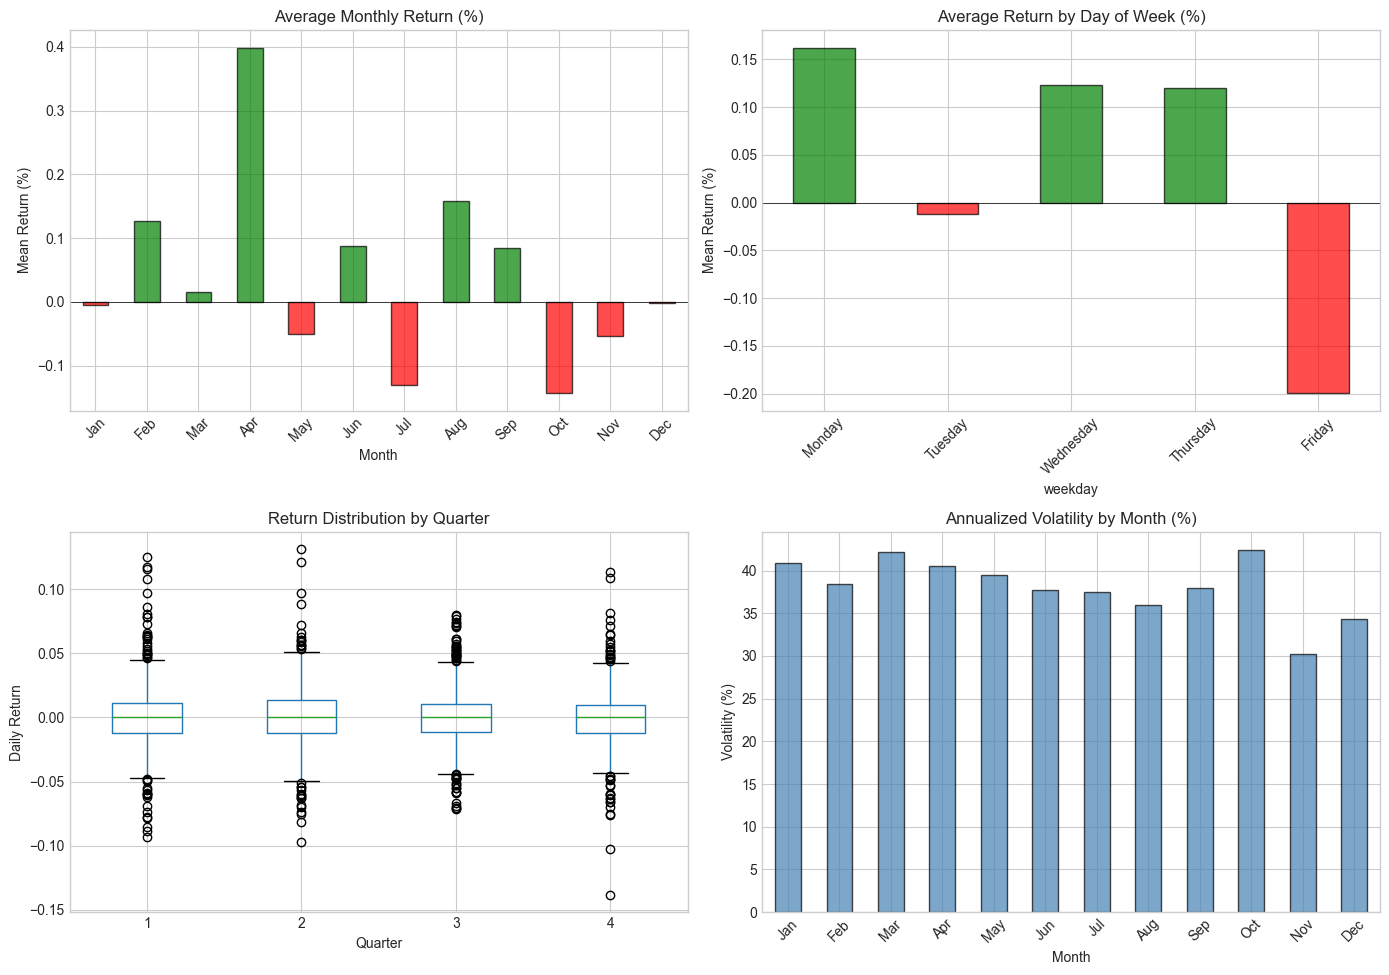


✓ Seasonality analysis complete!


In [29]:
# =============================================================================
# SEASONALITY FEATURES
# =============================================================================
print("="*70)
print("SEASONALITY FEATURES")
print("="*70)

# Create seasonality features
seasonality_df = pd.DataFrame(index=df_returns.index)

# Extract date components
seasonality_df['month'] = df_returns.index.month
seasonality_df['quarter'] = df_returns.index.quarter
seasonality_df['weekday'] = df_returns.index.weekday  # 0=Monday, 4=Friday
seasonality_df['day_of_month'] = df_returns.index.day
seasonality_df['week_of_year'] = df_returns.index.isocalendar().week.values

# Add coal returns for analysis
seasonality_df['coal_return'] = df_returns['coal_china_yzcm_ret']

print("Created seasonality features:")
print("  • month (1-12)")
print("  • quarter (1-4)")
print("  • weekday (0=Mon, 4=Fri)")
print("  • day_of_month (1-31)")
print("  • week_of_year (1-52)")

# Analyze seasonality patterns
print("\n--- Monthly Seasonality ---")
monthly_stats = seasonality_df.groupby('month')['coal_return'].agg(['mean', 'std', 'count'])
monthly_stats['mean_pct'] = monthly_stats['mean'] * 100
print(monthly_stats[['mean_pct', 'std', 'count']].round(4))

print("\n--- Day of Week Effect ---")
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekday_stats = seasonality_df.groupby('weekday')['coal_return'].agg(['mean', 'std', 'count'])
weekday_stats.index = weekday_names
weekday_stats['mean_pct'] = weekday_stats['mean'] * 100
print(weekday_stats[['mean_pct', 'std', 'count']].round(4))

# Statistical test for day-of-week effect
from scipy.stats import f_oneway
weekday_returns = [seasonality_df[seasonality_df['weekday']==i]['coal_return'].dropna() for i in range(5)]
f_stat, p_value = f_oneway(*weekday_returns)
print(f"\nANOVA test for weekday effect: F={f_stat:.2f}, p={p_value:.4f}")
print("  Significant weekday effect" if p_value < 0.05 else "  No significant weekday effect")

# Plot seasonality
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Monthly returns
ax1 = axes[0, 0]
monthly_means = seasonality_df.groupby('month')['coal_return'].mean() * 100
colors = ['green' if x > 0 else 'red' for x in monthly_means]
monthly_means.plot(kind='bar', ax=ax1, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_title('Average Monthly Return (%)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Mean Return (%)')
ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)

# Day of week returns
ax2 = axes[0, 1]
weekday_means = seasonality_df.groupby('weekday')['coal_return'].mean() * 100
colors = ['green' if x > 0 else 'red' for x in weekday_means]
weekday_means.plot(kind='bar', ax=ax2, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Average Return by Day of Week (%)')
ax2.set_xticklabels(weekday_names, rotation=45)
ax2.set_ylabel('Mean Return (%)')

# Quarterly boxplot
ax3 = axes[1, 0]
seasonality_df.boxplot(column='coal_return', by='quarter', ax=ax3)
ax3.set_title('Return Distribution by Quarter')
ax3.set_xlabel('Quarter')
ax3.set_ylabel('Daily Return')
plt.suptitle('')  # Remove automatic title

# Monthly volatility
ax4 = axes[1, 1]
monthly_vol = seasonality_df.groupby('month')['coal_return'].std() * np.sqrt(252) * 100
monthly_vol.plot(kind='bar', ax=ax4, color='steelblue', alpha=0.7, edgecolor='black')
ax4.set_title('Annualized Volatility by Month (%)')
ax4.set_xlabel('Month')
ax4.set_ylabel('Volatility (%)')
ax4.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)

plt.tight_layout()
plt.savefig('../data/processed/seasonality_analysis.png', dpi=150)
plt.show()

print("\n✓ Seasonality analysis complete!")

VARIANCE INFLATION FACTOR (VIF) ANALYSIS

VIF > 5: Moderate multicollinearity
VIF > 10: High multicollinearity (consider removing)

Analyzing 16 base return variables...

VIF Results (sorted by VIF):
--------------------------------------------------
  emerging_mkts_ret              VIF:     7.59  ⚠️ Moderate
  brent_crude_ret                VIF:     6.37  ⚠️ Moderate
  wti_crude_ret                  VIF:     4.88  ✓ OK
  china_etf_fxi_ret              VIF:     4.25  ✓ OK
  industrials_xli_ret            VIF:     3.20  ✓ OK
  steel_slx_ret                  VIF:     2.95  ✓ OK
  heating_oil_ret                VIF:     2.79  ✓ OK
  gasoline_ret                   VIF:     2.26  ✓ OK
  clean_energy_ret               VIF:     2.18  ✓ OK
  utilities_xlu_ret              VIF:     1.57  ✓ OK
  aud_usd_ret                    VIF:     1.54  ✓ OK
  eur_usd_ret                    VIF:     1.46  ✓ OK
  coal_china_yzcm_ret            VIF:     1.16  ✓ OK
  usd_index_ret                  VIF:     1.12

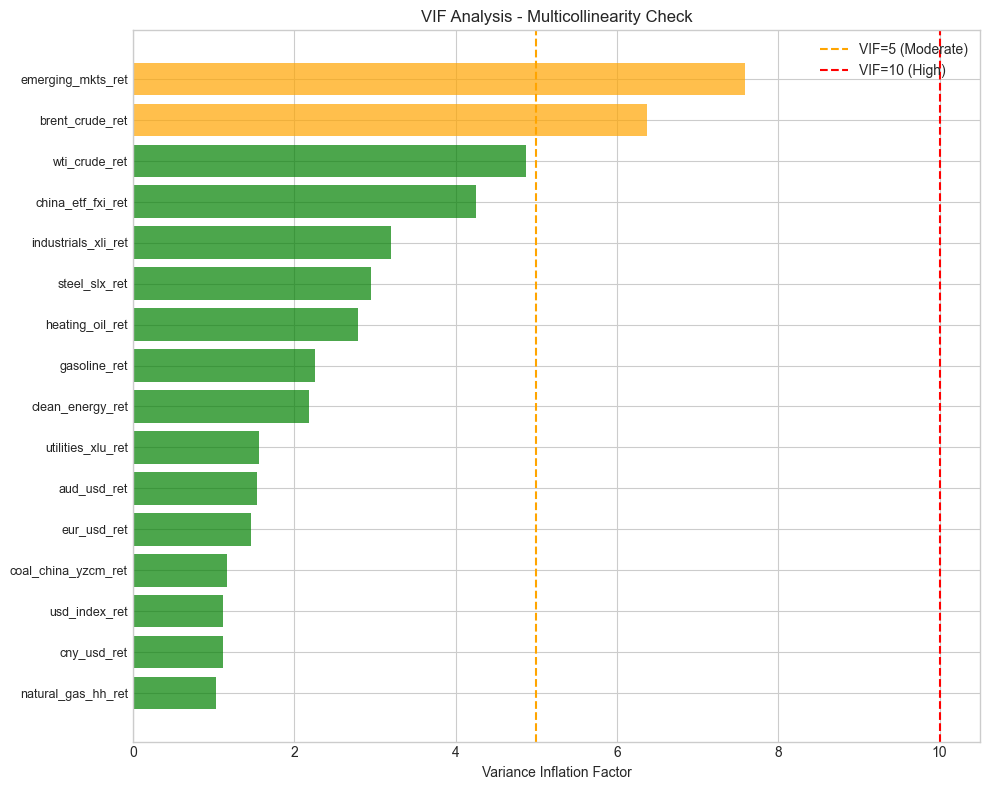


✓ VIF analysis complete!


In [30]:
# =============================================================================
# VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check
# =============================================================================
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("="*70)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("="*70)
print("\nVIF > 5: Moderate multicollinearity")
print("VIF > 10: High multicollinearity (consider removing)")

# Use a subset of features for VIF (too many features makes it slow)
# Select original returns only (not lagged) for cleaner analysis
vif_vars = [col for col in df_returns.columns if '_ret' in col and 'lag' not in col and 'ma' not in col and 'vol' not in col]
vif_data = df_returns[vif_vars].dropna()

print(f"\nAnalyzing {len(vif_vars)} base return variables...")

# Calculate VIF
vif_results = []
for i, col in enumerate(vif_data.columns):
    try:
        vif = variance_inflation_factor(vif_data.values, i)
        vif_results.append({'feature': col, 'VIF': vif})
    except:
        vif_results.append({'feature': col, 'VIF': np.nan})

vif_df = pd.DataFrame(vif_results).sort_values('VIF', ascending=False)

print("\nVIF Results (sorted by VIF):")
print("-"*50)
for _, row in vif_df.iterrows():
    status = "⚠️ HIGH" if row['VIF'] > 10 else ("⚠️ Moderate" if row['VIF'] > 5 else "✓ OK")
    print(f"  {row['feature']:<30} VIF: {row['VIF']:>8.2f}  {status}")

# Identify problematic features
high_vif = vif_df[vif_df['VIF'] > 10]['feature'].tolist()
moderate_vif = vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)]['feature'].tolist()

print(f"\n--- Summary ---")
print(f"High VIF (>10): {len(high_vif)} features")
print(f"Moderate VIF (5-10): {len(moderate_vif)} features")
print(f"OK VIF (<5): {len(vif_df) - len(high_vif) - len(moderate_vif)} features")

if high_vif:
    print(f"\nFeatures to consider removing: {high_vif}")

# Plot VIF
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['red' if v > 10 else ('orange' if v > 5 else 'green') for v in vif_df['VIF']]
bars = ax.barh(range(len(vif_df)), vif_df['VIF'], color=colors, alpha=0.7)
ax.set_yticks(range(len(vif_df)))
ax.set_yticklabels(vif_df['feature'], fontsize=9)
ax.axvline(x=5, color='orange', linestyle='--', label='VIF=5 (Moderate)')
ax.axvline(x=10, color='red', linestyle='--', label='VIF=10 (High)')
ax.set_xlabel('Variance Inflation Factor')
ax.set_title('VIF Analysis - Multicollinearity Check')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../data/processed/vif_analysis.png', dpi=150)
plt.show()

# Save results
vif_df.to_csv('../data/processed/vif_results.csv', index=False)
print("\n✓ VIF analysis complete!")

LASSO AND ELASTICNET REGRESSION

--- LASSO Regression (L1) ---
  α=0.0001: Val RMSE=0.022440, Non-zero features: 117/151
  α=0.001 : Val RMSE=0.021069, Non-zero features: 13/151
  α=0.01  : Val RMSE=0.021370, Non-zero features: 0/151
  α=0.1   : Val RMSE=0.021370, Non-zero features: 0/151

  Best Lasso: α=0.001

--- ElasticNet Regression (L1 + L2) ---
  α=0.001, L1_ratio=0.5: Val RMSE=0.021370, Non-zero: 42
  α=0.01, L1_ratio=0.5: Val RMSE=0.021370, Non-zero: 0
  α=0.001, L1_ratio=0.9: Val RMSE=0.021087, Non-zero: 14
  α=0.01, L1_ratio=0.9: Val RMSE=0.021370, Non-zero: 0

--- Test Set Evaluation ---
  Ridge (α=100)            : RMSE=0.023562, Dir Acc=46.1%
  Lasso (α=0.001)          : RMSE=0.021355, Dir Acc=53.9%
  ElasticNet               : RMSE=0.021382, Dir Acc=54.2%
  Gradient Boosting        : RMSE=0.021923, Dir Acc=49.5%


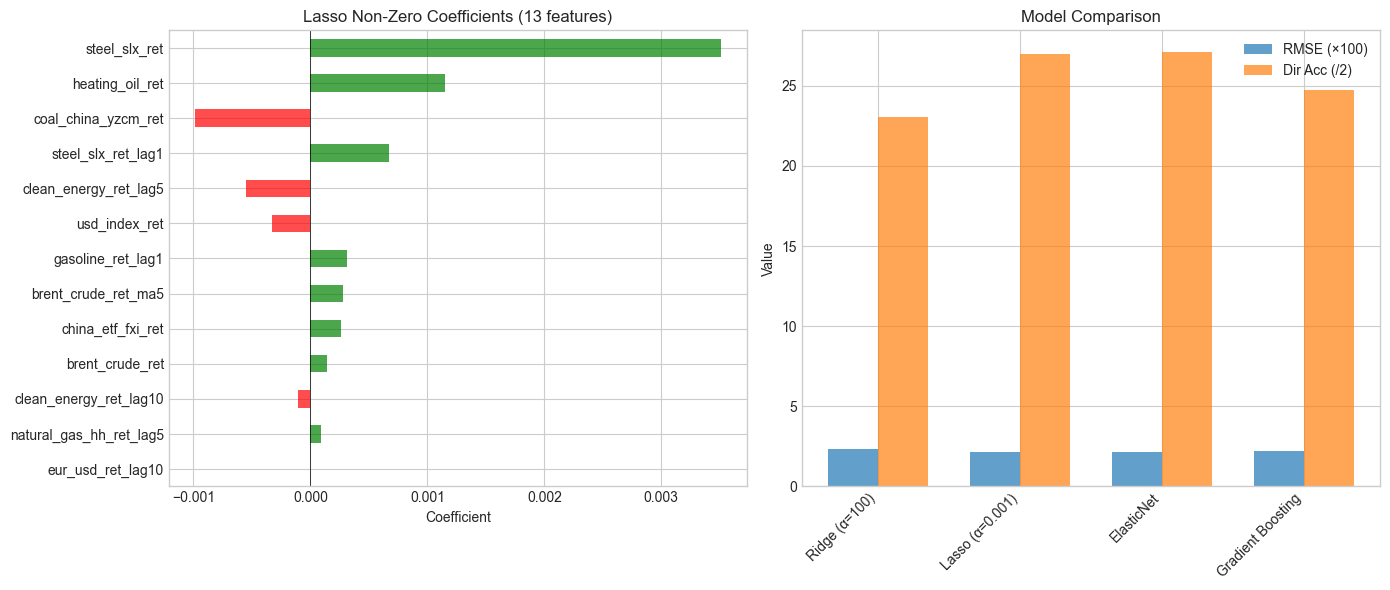


✓ Lasso and ElasticNet analysis complete!


In [31]:
# =============================================================================
# LASSO AND ELASTICNET REGRESSION
# =============================================================================
from sklearn.linear_model import Lasso, ElasticNet

print("="*70)
print("LASSO AND ELASTICNET REGRESSION")
print("="*70)

# Lasso (L1 regularization) - promotes sparsity
print("\n--- LASSO Regression (L1) ---")
lasso_alphas = [0.0001, 0.001, 0.01, 0.1]
lasso_results = []

for alpha in lasso_alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    
    train_pred = lasso.predict(X_train_scaled)
    val_pred = lasso.predict(X_val_scaled)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    n_nonzero = np.sum(lasso.coef_ != 0)
    
    lasso_results.append({
        'alpha': alpha, 'train_rmse': train_rmse, 'val_rmse': val_rmse, 
        'n_features': n_nonzero, 'model': lasso
    })
    print(f"  α={alpha:<6}: Val RMSE={val_rmse:.6f}, Non-zero features: {n_nonzero}/{len(X_train.columns)}")

# Best Lasso
best_lasso_idx = np.argmin([r['val_rmse'] for r in lasso_results])
best_lasso = lasso_results[best_lasso_idx]['model']
best_lasso_alpha = lasso_results[best_lasso_idx]['alpha']
print(f"\n  Best Lasso: α={best_lasso_alpha}")

# ElasticNet (L1 + L2 regularization)
print("\n--- ElasticNet Regression (L1 + L2) ---")
enet_params = [(0.001, 0.5), (0.01, 0.5), (0.001, 0.9), (0.01, 0.9)]
enet_results = []

for alpha, l1_ratio in enet_params:
    enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42)
    enet.fit(X_train_scaled, y_train)
    
    val_pred = enet.predict(X_val_scaled)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    n_nonzero = np.sum(enet.coef_ != 0)
    
    enet_results.append({
        'alpha': alpha, 'l1_ratio': l1_ratio, 'val_rmse': val_rmse,
        'n_features': n_nonzero, 'model': enet
    })
    print(f"  α={alpha}, L1_ratio={l1_ratio}: Val RMSE={val_rmse:.6f}, Non-zero: {n_nonzero}")

# Best ElasticNet
best_enet_idx = np.argmin([r['val_rmse'] for r in enet_results])
best_enet = enet_results[best_enet_idx]['model']

# Evaluate on test set
print("\n--- Test Set Evaluation ---")
models_to_eval = {
    'Ridge (α=100)': ridge_final,
    f'Lasso (α={best_lasso_alpha})': best_lasso,
    'ElasticNet': best_enet,
    'Gradient Boosting': gb_final
}

comparison_results = []
for name, model in models_to_eval.items():
    if 'Ridge' in name or 'Lasso' in name or 'Elastic' in name:
        test_pred = model.predict(X_test_scaled)
    else:
        test_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    mae = mean_absolute_error(y_test, test_pred)
    dir_acc = np.mean(np.sign(test_pred) == np.sign(y_test)) * 100
    
    comparison_results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'Dir_Acc': dir_acc})
    print(f"  {name:<25}: RMSE={rmse:.6f}, Dir Acc={dir_acc:.1f}%")

# Plot coefficient comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Lasso coefficients (non-zero only)
ax1 = axes[0]
lasso_coef = pd.Series(best_lasso.coef_, index=X_train.columns)
lasso_nonzero = lasso_coef[lasso_coef != 0].sort_values(key=abs, ascending=True)
if len(lasso_nonzero) > 0:
    colors = ['green' if c > 0 else 'red' for c in lasso_nonzero]
    lasso_nonzero.tail(20).plot(kind='barh', ax=ax1, color=colors[-20:], alpha=0.7)
    ax1.set_title(f'Lasso Non-Zero Coefficients ({len(lasso_nonzero)} features)')
    ax1.set_xlabel('Coefficient')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
else:
    ax1.text(0.5, 0.5, 'All coefficients are zero', ha='center', va='center')
    ax1.set_title('Lasso Coefficients')

# Model comparison
ax2 = axes[1]
comp_df = pd.DataFrame(comparison_results)
x = np.arange(len(comp_df))
width = 0.35
ax2.bar(x - width/2, comp_df['RMSE']*100, width, label='RMSE (×100)', alpha=0.7)
ax2.bar(x + width/2, comp_df['Dir_Acc']/2, width, label='Dir Acc (/2)', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(comp_df['Model'], rotation=45, ha='right')
ax2.set_ylabel('Value')
ax2.set_title('Model Comparison')
ax2.legend()

plt.tight_layout()
plt.savefig('../data/processed/lasso_elasticnet.png', dpi=150)
plt.show()

print("\n✓ Lasso and ElasticNet analysis complete!")

FEATURE REMOVAL FRAGILITY TEST

Removing top features one by one to test model robustness...
Top 5 features: ['steel_slx_ret', 'heating_oil_ret', 'wti_crude_ret', 'coal_china_yzcm_ret_ma21', 'clean_energy_ret']

Baseline (all features): RMSE=0.021923, Dir Acc=49.5%
  Remove steel_slx_ret                      : RMSE=0.022049 (+0.6%), Dir Acc=48.7%
  Remove heating_oil_ret                    : RMSE=0.022002 (+0.4%), Dir Acc=50.0%
  Remove wti_crude_ret                      : RMSE=0.022232 (+1.4%), Dir Acc=42.1%
  Remove coal_china_yzcm_ret_ma21           : RMSE=0.022043 (+0.5%), Dir Acc=47.6%
  Remove clean_energy_ret                   : RMSE=0.022134 (+1.0%), Dir Acc=47.1%

  Remove ALL TOP 5 features: RMSE=0.022218 (+1.3%), Dir Acc=46.9%


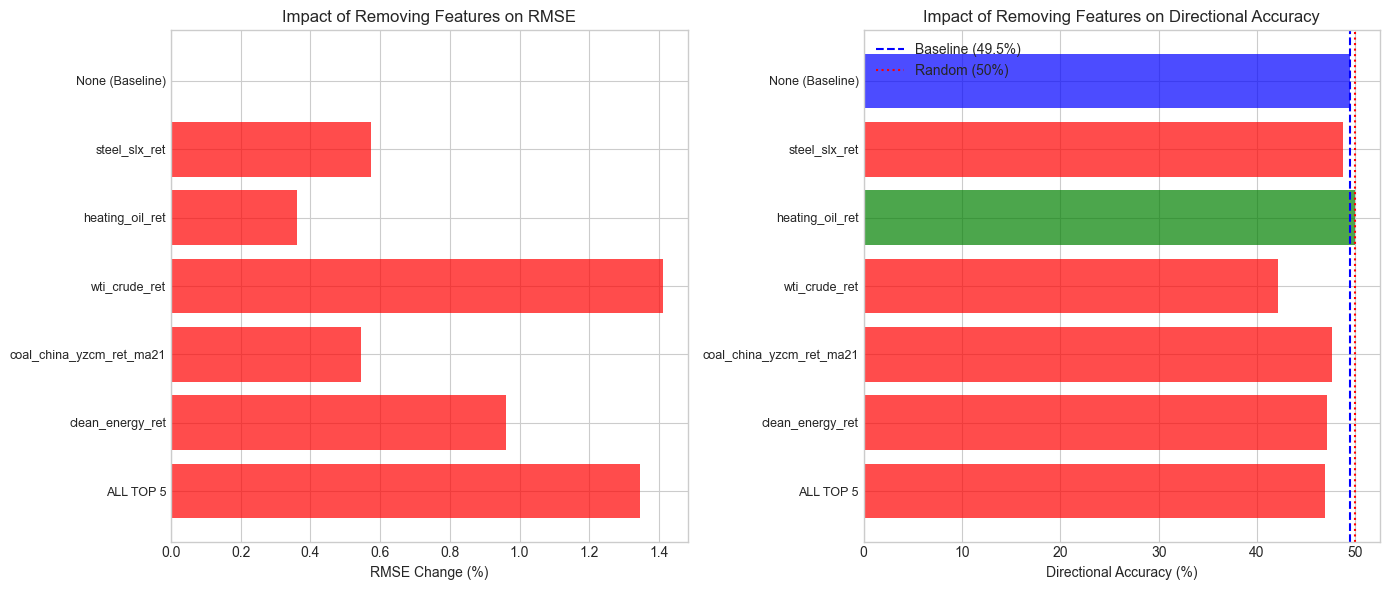


--- Fragility Assessment ---
✓ Model is ROBUST: No single feature removal causes >5% RMSE increase

✓ Fragility analysis complete!


In [32]:
# =============================================================================
# FEATURE REMOVAL FRAGILITY TEST
# =============================================================================
print("="*70)
print("FEATURE REMOVAL FRAGILITY TEST")
print("="*70)
print("\nRemoving top features one by one to test model robustness...")

# Get top 5 features by importance
top_features = perm_imp_df.head(5)['feature'].tolist()
print(f"Top 5 features: {top_features}")

# Baseline performance (all features)
baseline_pred = gb_final.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_dir_acc = np.mean(np.sign(baseline_pred) == np.sign(y_test)) * 100

print(f"\nBaseline (all features): RMSE={baseline_rmse:.6f}, Dir Acc={baseline_dir_acc:.1f}%")

# Remove features one by one
fragility_results = [{'removed': 'None (Baseline)', 'rmse': baseline_rmse, 'dir_acc': baseline_dir_acc, 'rmse_change': 0}]

for feature in top_features:
    # Create dataset without this feature
    X_train_reduced = X_train.drop(columns=[feature])
    X_val_reduced = X_val.drop(columns=[feature])
    X_test_reduced = X_test.drop(columns=[feature])
    
    # Train new model
    gb_reduced = GradientBoostingRegressor(
        n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42
    )
    gb_reduced.fit(X_train_reduced, y_train)
    
    # Evaluate
    test_pred = gb_reduced.predict(X_test_reduced)
    rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    dir_acc = np.mean(np.sign(test_pred) == np.sign(y_test)) * 100
    rmse_change = ((rmse - baseline_rmse) / baseline_rmse) * 100
    
    fragility_results.append({
        'removed': feature, 'rmse': rmse, 'dir_acc': dir_acc, 'rmse_change': rmse_change
    })
    print(f"  Remove {feature:<35}: RMSE={rmse:.6f} ({rmse_change:+.1f}%), Dir Acc={dir_acc:.1f}%")

# Remove ALL top 5 features
X_train_no_top5 = X_train.drop(columns=top_features)
X_test_no_top5 = X_test.drop(columns=top_features)

gb_no_top5 = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
gb_no_top5.fit(X_train_no_top5, y_train)
test_pred_no_top5 = gb_no_top5.predict(X_test_no_top5)
rmse_no_top5 = np.sqrt(mean_squared_error(y_test, test_pred_no_top5))
dir_acc_no_top5 = np.mean(np.sign(test_pred_no_top5) == np.sign(y_test)) * 100
rmse_change_no_top5 = ((rmse_no_top5 - baseline_rmse) / baseline_rmse) * 100

fragility_results.append({
    'removed': 'ALL TOP 5', 'rmse': rmse_no_top5, 'dir_acc': dir_acc_no_top5, 'rmse_change': rmse_change_no_top5
})
print(f"\n  Remove ALL TOP 5 features: RMSE={rmse_no_top5:.6f} ({rmse_change_no_top5:+.1f}%), Dir Acc={dir_acc_no_top5:.1f}%")

# Plot fragility analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fragility_df = pd.DataFrame(fragility_results)

# RMSE change
ax1 = axes[0]
colors = ['green' if x <= 0 else 'red' for x in fragility_df['rmse_change']]
colors[0] = 'blue'  # Baseline
ax1.barh(range(len(fragility_df)), fragility_df['rmse_change'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(fragility_df)))
ax1.set_yticklabels(fragility_df['removed'], fontsize=9)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('RMSE Change (%)')
ax1.set_title('Impact of Removing Features on RMSE')
ax1.invert_yaxis()

# Directional accuracy
ax2 = axes[1]
colors2 = ['red' if x < baseline_dir_acc else 'green' for x in fragility_df['dir_acc']]
colors2[0] = 'blue'  # Baseline
ax2.barh(range(len(fragility_df)), fragility_df['dir_acc'], color=colors2, alpha=0.7)
ax2.set_yticks(range(len(fragility_df)))
ax2.set_yticklabels(fragility_df['removed'], fontsize=9)
ax2.axvline(x=baseline_dir_acc, color='blue', linestyle='--', label=f'Baseline ({baseline_dir_acc:.1f}%)')
ax2.axvline(x=50, color='red', linestyle=':', label='Random (50%)')
ax2.set_xlabel('Directional Accuracy (%)')
ax2.set_title('Impact of Removing Features on Directional Accuracy')
ax2.legend()
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('../data/processed/fragility_analysis.png', dpi=150)
plt.show()

# Save results
fragility_df.to_csv('../data/processed/fragility_results.csv', index=False)

print("\n--- Fragility Assessment ---")
max_rmse_increase = fragility_df['rmse_change'].max()
if max_rmse_increase < 5:
    print("✓ Model is ROBUST: No single feature removal causes >5% RMSE increase")
elif max_rmse_increase < 10:
    print("⚠️ Model has MODERATE fragility: Some features cause 5-10% RMSE increase")
else:
    print("⚠️ Model is FRAGILE: Removing top features causes >10% RMSE increase")

print("\n✓ Fragility analysis complete!")